<a href="https://colab.research.google.com/github/barbaradinizabreu/ICD-UFMG/blob/main/TP_ICD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Entrega 2 - Introdução à Ciência de Dados

#### Integrantes
Bárbara Diniz Abreu - 2023001670  
Beatriz Camilly Gulart Pereira - 2023087753  
Caio Brega Có Silva - 2023070842  
João Paulo Moura Furtado - 2023001891  


--------------------

## Introdução

No Brasil o sistema prisional sempre foi um assunto polêmico e rodeado de problemas. Entre os principais estão: a superlotação, as condições de infraestrutura e a qualidade dos serviços oferecidos, que impactam diretamente tanto na segurança quanto no bem-estar das pessoas privadas de liberdade. Com isso, entender algumas dessas deficiências é interessante para apoiar e incentivar políticas públicas mais eficazes.

Diante desse contexto, realizamos as seguintes perguntas de pesquisa que servirão de base para todo o trabalho:

##### 1 - É possível prever o número de pessoas privadas de liberdade em um estado nos próximos anos a partir do histórico da população carcerária e da disponibilidade de vagas no sistema prisional?

##### 2 - É possível relacionar a quantidade de óbitos naturais/por motivos de saúde com a qualidade da área médica das prisões?

##### 3 - Existe uma correlação entre a oferta de serviços de assistência social nas unidades prisionais com o percentual de presos que trabalham e/ou estudam?

##### 4 - Existe uma correlação entre os grupos de crime pelos quais os detentos foram condenados e a incidência de óbitos prisionais de natureza criminal?

##Banco de dados
O conjunto de dados utilizado neste trabalho é o **Levantamento Nacional de Informações Penitenciárias**, disponibilizado pela Secretaria Nacional de Políticas Penais (SENAPPEN), órgão vinculado ao Ministério da Justiça e Segurança Pública. Esse levantamento faz parte do banco de dados do Sistema de Informações do Departamento Penitenciário  Nacional (SISDEPEN), que reúne informações de todas as unidades prisionais do Brasil.  

A base contém dados censitários e agregados sobre a realidade dos sistema prisional brasileiro, abrangendo aspectos como infraestrutura das unidades, recursos humanos, capacidade, população prisional e perfil das pessoas privadas de liberdade.  

A coleta dos dados é realizada por meio de um formulário, preenchido pelos responsáveis de cada unidade prisional, conforme diretrizes estabelecidas pela SENAPPEN. Esse formulário também foi utilizado neste trabalho como dicionário de dados, auxiliando na compreensão e categorização das variáveis disponíveis.

**Referências de Dados:**   
[SISDEPEN - Bases de Dados](https://www.gov.br/senappen/pt-br/servicos/sisdepen/bases-de-dados)

[SISDEPEN - Formulário de coleta](https://www.gov.br/senappen/pt-br/servicos/sisdepen/bases-de-dados/arquivos/formulario-sobre-informacoes-prisionais.pdf)

## Atividades desenvolvidas por cada membro
Para realizar esse trabalho, optamos por dividir as tarefas da seguinte forma:  (talvez adicionar uma tabela pra melhorar a visualização)  

Beatriz -   
Bárbara  
João  
Caio  

A escolha do banco de dados e a formulação das perguntas foram realizadas de forma colaborativa por todos os membros do grupo.

## Importação dos dados e bibliotecas

In [207]:
!pip install squarify

In [208]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import LogNorm
import squarify
import scipy.stats as stats
from scipy.stats import ttest_rel
from scipy.stats import spearmanr
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer

!gdown --folder https://drive.google.com/drive/folders/1lJmdpSd02WE6FaUpB8_lGBqRqEElGvaQ?usp=sharing --output .

dados = pd.read_csv('/content/sisdepen_1_17_csv.csv', encoding='utf-8', sep=';')

Retrieving folder contents
Processing file 1lwLd-VJJgsRyRuNEviTRyiSYN4uPwAMi sisdepen_1_17_csv.csv
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=1lwLd-VJJgsRyRuNEviTRyiSYN4uPwAMi
From (redirected): https://drive.google.com/uc?id=1lwLd-VJJgsRyRuNEviTRyiSYN4uPwAMi&confirm=t&uuid=e305e176-a200-42ca-bbbb-d324cc2984ba
To: /content/sisdepen_1_17_csv.csv
100% 125M/125M [00:02<00:00, 46.5MB/s]
Download completed


/tmp/ipython-input-208-2652248367.py:20: DtypeWarning: Columns (37,129,131,188,223,390,1737,1740) have mixed types. Specify dtype option on import or set low_memory=False.
  dados = pd.read_csv('/content/sisdepen_1_17_csv.csv', encoding='utf-8', sep=';')


## Limpeza dos Dados

O banco de dados possuía, inicialmente, 1782 colunas com informações sobre presídios de todo o Brasil.

Selecionando as colunas 'Situação de Preenchimento' e 'Situação do Estabelecimento' percebemos uma uniformidade. Dentre as respostas possíveis, todas foram 'validado' e 'ativo', respectivamente. Isso significa que as informações recolhidas via questionário por formulário foram preenchidas em totalidade e que todos os presídios registrados estão em operação.

Pensando nessa uniformidade, removemos essas colunas visto que elas não acrescentam informações relevantes que permitam a distinção entre os dados.


In [209]:
def existe_uniformidade(dados, coluna, resposta_padrao):
    return (dados[coluna] == resposta_padrao).all()

print(existe_uniformidade(dados, 'Situação de Preenchimento', 'Validado'))
print(existe_uniformidade(dados, 'Situação do Estabelecimento', 'Ativo'))

True
True


As demais colunas retiradas foram removidas por não serem interessantes para a realização do nosso trabalho prático.

In [210]:
# Prefixos gerais para remoção
prefixos = [
    'Situação de Preenchimento',
    'Situação do Estabelecimento',
    'Outras Denominações',
    'Âmbito',
    'Município',
    'Endereço',
    'Bairro',
    'CEP',
    'Código IBGE',
    'Telefone Principal',
    '1.4 Gestão do estabelecimento',
    '1.5 Quais serviços são terceirizados?',
    '5.2 Quantidade de pessoas privadas de liberdade por cor de pele/raça/etnia',
    '5.3 Quantidade de pessoas privadas de liberdade por procedência',
    '5.4 Estado civil',
    '5.5 Pessoas com deficiência',
    '5.6 Quantidade de pessoas privadas de liberdade por grau de instrução',
    '5.7 Número de pessoas privadas de liberdade com documentos pessoais',
    '5.8 Quantidade de pessoas privadas de liberdade por nacionalidade',
    '5.9 Faixa etária dos filhos que estão no estabelecimento (aplicável apenas para estabelecimentos com mulheres)',
    '5.10 Número de filhos/as',
    '5.11 Número de pessoas privadas de liberdade que possuem visitantes cadastrados',
    '5.14 Quantidade de incidências por tipo penal | Número de pessoas privadas de liberdade com informação sobre tipificação criminal',
    '5.14 Quantidade de incidências por tipo penal | Número de pessoas privadas de liberdade sem informação sobre tipificação criminal',
    '7.3 Quantidade de visitas registradas no período de referência',
    '7.4. Total de apreensões no período de referência',
    '7.5 Foi realizada visita(s) de inspeção no período de referência?'
]

# Colunas específicas a serem removidas
colunas_especificas = [
    '1.1 Estabelecimento originalmente destinado a pessoa privadas de liberdade do sexo',
    '1.2 Tipo de estabelecimento - originalmente destinado',
    '1.8 Possui regimento interno?',
    '1.9 O regimento interno é específico para este estabelecimento ou se aplica aos demais estabelecimentos do Estado?',
    '1.6 Data de inauguração do estabelecimento',
    '1.7 O estabelecimento foi concebido como estabelecimento penal ou foi construído para outra utilização e foi adaptado?',
    '5.14 Quantidade de incidências por tipo penal | Masculino',
    '5.14 Quantidade de incidências por tipo penal | Feminino'
]

colunas_por_prefixo = [
    col for col in dados.columns
    if any(col.startswith(pref) for pref in prefixos)
]

colunas_para_remover = colunas_por_prefixo + colunas_especificas
dados_filtrados = dados.drop(columns=colunas_para_remover)

# Substitui espaços vazios por 'NaN'
dados_filtrados = dados_filtrados.replace(r'^\s*$', np.nan, regex=True)# Prefixos gerais para remoção
prefixos = [
    'Situação de Preenchimento',
    'Situação do Estabelecimento',
    'Outras Denominações',
    'Âmbito',
    'Município',
    'Endereço',
    'Bairro',
    'CEP',
    'Código IBGE',
    'Telefone Principal',
    '1.4 Gestão do estabelecimento',
    '1.5 Quais serviços são terceirizados?',
    '5.2 Quantidade de pessoas privadas de liberdade por cor de pele/raça/etnia',
    '5.3 Quantidade de pessoas privadas de liberdade por procedência',
    '5.4 Estado civil',
    '5.5 Pessoas com deficiência',
    '5.6 Quantidade de pessoas privadas de liberdade por grau de instrução',
    '5.7 Número de pessoas privadas de liberdade com documentos pessoais',
    '5.8 Quantidade de pessoas privadas de liberdade por nacionalidade',
    '5.9 Faixa etária dos filhos que estão no estabelecimento (aplicável apenas para estabelecimentos com mulheres)',
    '5.10 Número de filhos/as',
    '5.11 Número de pessoas privadas de liberdade que possuem visitantes cadastrados',
    '5.14 Quantidade de incidências por tipo penal | Número de pessoas privadas de liberdade com informação sobre tipificação criminal',
    '5.14 Quantidade de incidências por tipo penal | Número de pessoas privadas de liberdade sem informação sobre tipificação criminal',
    '7.3 Quantidade de visitas registradas no período de referência',
    '7.4. Total de apreensões no período de referência',
    '7.5 Foi realizada visita(s) de inspeção no período de referência?'
]

# Colunas específicas a serem removidas
colunas_especificas = [
    '1.1 Estabelecimento originalmente destinado a pessoa privadas de liberdade do sexo',
    '1.2 Tipo de estabelecimento - originalmente destinado',
    '1.8 Possui regimento interno?',
    '1.9 O regimento interno é específico para este estabelecimento ou se aplica aos demais estabelecimentos do Estado?',
    '1.6 Data de inauguração do estabelecimento',
    '1.7 O estabelecimento foi concebido como estabelecimento penal ou foi construído para outra utilização e foi adaptado?',
    '5.14 Quantidade de incidências por tipo penal | Masculino',
    '5.14 Quantidade de incidências por tipo penal | Feminino'
]

colunas_por_prefixo = [
    col for col in dados.columns
    if any(col.startswith(pref) for pref in prefixos)
]

colunas_para_remover = colunas_por_prefixo + colunas_especificas
dados_filtrados = dados.drop(columns=colunas_para_remover)

# Substitui espaços vazios por 'NaN'
dados_filtrados = dados_filtrados.replace(r'^\s*$', np.nan, regex=True)

In [211]:
'''colunas restantes

for col in dados_filtrados.columns:
    print(f"'{col}'")'''

'colunas restantes\n\nfor col in dados_filtrados.columns:\n    print(f"\'{col}\'")'

## Pergunta 1

**É possível prever o número de pessoas privadas de liberdade em um estado nos próximos anos a partir do histórico da população carcerária e da disponibilidade de vagas no sistema prisional?**


Para essa análise serão investigadas a evolução temporal da população carcerária por estado e a relação entre capacidade total de vagas e número total de presos

In [212]:
colunas_usadas = [
    'Ano', 'UF',
    '1.3 Capacidade do estabelecimento | Presos provisórios | Total',
    '1.3 Capacidade do estabelecimento | Regime fechado | Total',
    '1.3 Capacidade do estabelecimento | Regime semiaberto | Total',
    '1.3 Capacidade do estabelecimento | Regime aberto | Total',
    '1.3 Capacidade do estabelecimento | Regime Disciplinar Diferenciado (RDD) | Total',
    '1.3 Capacidade do estabelecimento | Medidas de segurança de internação | Total',
    '1.3 Capacidade do estabelecimento | Outro(s). Qual(is)? | Total',
    '1.3 Capacidade do estabelecimento | Masculino | Total',
    '1.3 Capacidade do estabelecimento | Feminino | Total',
    '5.1 Quantidade de pessoas privadas de liberdade por faixa etária | 18 a 24 anos | Total',
    '5.1 Quantidade de pessoas privadas de liberdade por faixa etária | 25 a 29 anos | Total',
    '5.1 Quantidade de pessoas privadas de liberdade por faixa etária | 30 a 34 anos | Total',
    '5.1 Quantidade de pessoas privadas de liberdade por faixa etária | 35 a 45 anos | Total',
    '5.1 Quantidade de pessoas privadas de liberdade por faixa etária | 46 a 60 anos | Total',
    '5.1 Quantidade de pessoas privadas de liberdade por faixa etária | 61 a 70 anos | Total',
    '5.1 Quantidade de pessoas privadas de liberdade por faixa etária | Mais de 70 anos | Total',
    '5.1 Quantidade de pessoas privadas de liberdade por faixa etária | Não informado | Total',
    '5.1 Quantidade de pessoas privadas de liberdade por faixa etária | Total'
]

dados_filtrados1 = dados_filtrados[colunas_usadas]
# Remove as linhas com todos os valores ausentes
dados_filtrados1 = dados_filtrados1.dropna(how='all')

for col in colunas_usadas[2:]:
    dados_filtrados1[col] = pd.to_numeric(dados_filtrados1[col], errors='coerce')

# Agrupa por ano e UF e soma os dados
df_uf_ano = dados_filtrados1.groupby(['Ano', 'UF']).sum().reset_index()
df_uf_ano.head(27)


,Ano,UF,1.3 Capacidade do estabelecimento | Presos provisórios | Total,1.3 Capacidade do estabelecimento | Regime fechado | Total,1.3 Capacidade do estabelecimento | Regime semiaberto | Total,1.3 Capacidade do estabelecimento | Regime aberto | Total,1.3 Capacidade do estabelecimento | Regime Disciplinar Diferenciado (RDD) | Total,1.3 Capacidade do estabelecimento | Medidas de segurança de internação | Total,1.3 Capacidade do estabelecimento | Outro(s). Qual(is)? | Total,1.3 Capacidade do estabelecimento | Masculino | Total,1.3 Capacidade do estabelecimento | Feminino | Total,5.1 Quantidade de pessoas privadas de liberdade por faixa etária | 18 a 24 anos | Total,5.1 Quantidade de pessoas privadas de liberdade por faixa etária | 25 a 29 anos | Total,5.1 Quantidade de pessoas privadas de liberdade por faixa etária | 30 a 34 anos | Total,5.1 Quantidade de pessoas privadas de liberdade por faixa etária | 35 a 45 anos | Total,5.1 Quantidade de pessoas privadas de liberdade por faixa etária | 46 a 60 anos | Total,5.1 Quantidade de pessoas privadas de liberdade por faixa etária | 61 a 70 anos | Total,5.1 Quantidade de pessoas privadas de liberdade por faixa etária | Mais de 70 anos | Total,5.1 Quantidade de pessoas privadas de liberdade por faixa etária | Não informado | Total,5.1 Quantidade de pessoas privadas de liberdade por faixa etária | Total
0,2016,AC,610.0,2218.0,1956.0,0.0,70.0,1.0,0.0,4296.0,559.0,1239.0,859.0,628.0,541.0,106.0,14.0,4.0,10.0,3401.0
1,2016,AL,760.0,1984.0,1.0,0.0,0.0,83.0,0.0,2609.0,219.0,2343.0,1868.0,1118.0,973.0,370.0,82.0,14.0,343.0,7111.0
2,2016,AM,2355.0,901.0,264.0,946.0,1.0,25.0,0.0,4123.0,369.0,3697.0,2371.0,1555.0,1398.0,377.0,41.0,2.0,201.0,9642.0
3,2016,AP,534.0,560.0,566.0,10.0,0.0,0.0,14.0,1581.0,103.0,732.0,738.0,504.0,581.0,132.0,7.0,1.0,9.0,2704.0
4,2016,BA,3082.0,771.0,946.0,0.0,432.0,90.0,5036.0,9885.0,472.0,4128.0,3018.0,2394.0,1860.0,701.0,222.0,16.0,184.0,12523.0
5,2016,CE,9553.0,3182.0,965.0,222.0,0.0,153.0,2.0,13319.0,758.0,6844.0,5403.0,4032.0,4681.0,1856.0,16.0,0.0,1179.0,24011.0
6,2016,DF,1744.0,3464.0,2064.0,0.0,0.0,123.0,0.0,6690.0,705.0,4242.0,3655.0,2847.0,3109.0,945.0,82.0,4.0,74.0,14958.0
7,2016,ES,5439.0,5428.0,2579.0,0.0,10.0,131.0,4.0,12296.0,1295.0,4837.0,2918.0,1977.0,2039.0,935.0,122.0,18.0,1725.0,14571.0
8,2016,GO,4243.0,3292.0,1284.0,531.0,133.0,4.0,66.0,8717.0,836.0,2987.0,2349.0,1457.0,1248.0,523.0,102.0,8.0,206.0,8880.0
9,2016,MA,3161.0,1508.0,800.0,106.0,5.0,1.0,12.0,5308.0,285.0,1944.0,1529.0,986.0,796.0,308.0,56.0,24.0,0.0,5643.0


**Gráficos para ilustrar o efeito das váriaveis independentes**



/tmp/ipython-input-213-3620260666.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


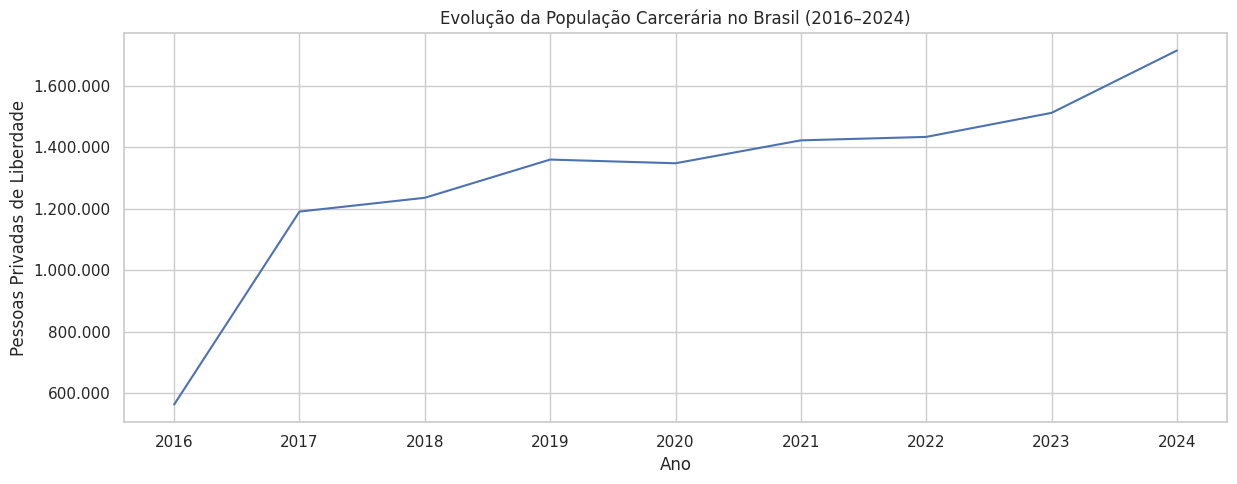

In [213]:
import matplotlib.ticker as ticker
df_brasil_ano = dados_filtrados1.groupby('Ano').sum(numeric_only=True).reset_index()

#População carcerária total por ano
plt.figure(figsize=(12, 5))
sns.lineplot(
    data=df_brasil_ano,
    x='Ano',
    y='5.1 Quantidade de pessoas privadas de liberdade por faixa etária | Total',
    ci=None
)
plt.title('Evolução da População Carcerária no Brasil (2016–2024)')
plt.xlabel('Ano')
plt.ylabel('Pessoas Privadas de Liberdade')
plt.tight_layout()
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'.replace(",", ".")))
plt.show()

/tmp/ipython-input-214-3715004344.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(
/tmp/ipython-input-214-3715004344.py:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


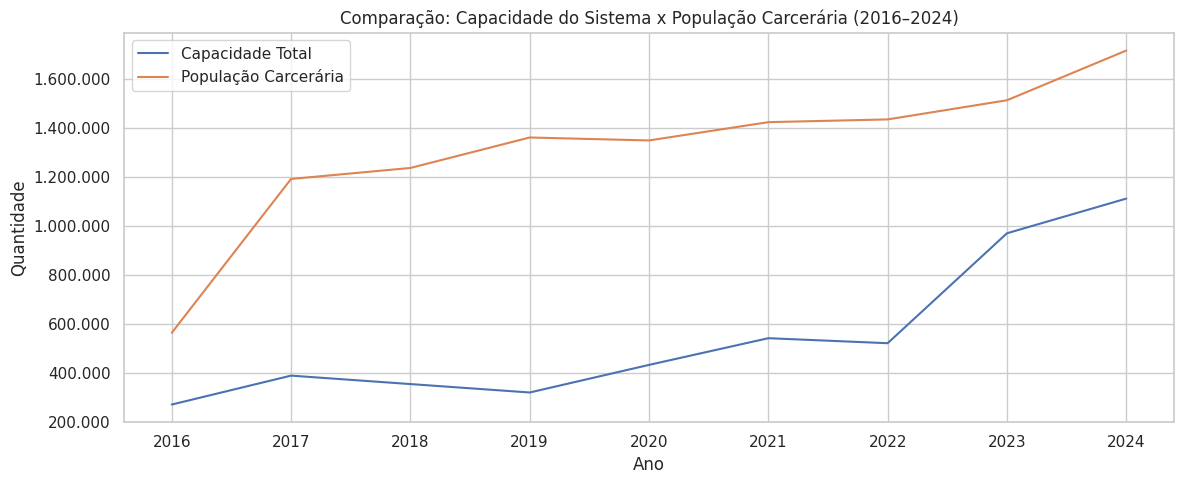

In [214]:
dados_filtrados1['Capacidade Total'] = (
    dados_filtrados1['1.3 Capacidade do estabelecimento | Masculino | Total'] +
    dados_filtrados1['1.3 Capacidade do estabelecimento | Feminino | Total']
)

df_brasil_ano = dados_filtrados1.groupby('Ano').sum(numeric_only=True).reset_index()

plt.figure(figsize=(12, 5))
sns.lineplot(
    data=df_brasil_ano,
    x='Ano',
    y='Capacidade Total',
    ci=None,
    label='Capacidade Total'
)
sns.lineplot(
    data=df_brasil_ano,
    x='Ano',
    y='5.1 Quantidade de pessoas privadas de liberdade por faixa etária | Total',
    ci=None,
    label='População Carcerária'
)
plt.title('Comparação: Capacidade do Sistema x População Carcerária (2016–2024)')
plt.xlabel('Ano')
plt.ylabel('Quantidade')

plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'.replace(",", ".")))

plt.legend()
plt.tight_layout()
plt.show()

**Gráfico para ilustrar o aumento das capacidades carcerárias nos diferentes tipos de regime**

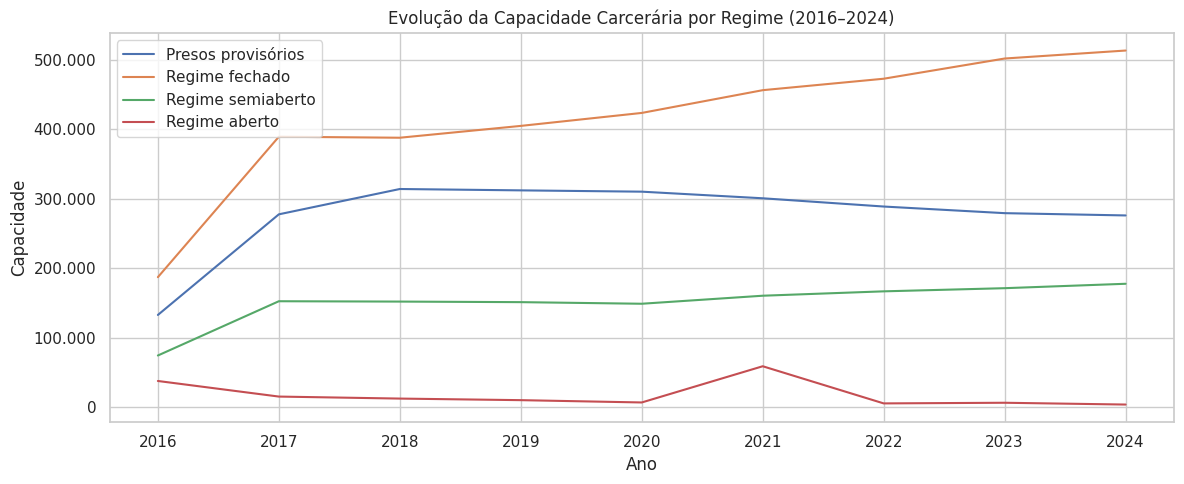

In [215]:
regimes = [
    '1.3 Capacidade do estabelecimento | Presos provisórios | Total',
    '1.3 Capacidade do estabelecimento | Regime fechado | Total',
    '1.3 Capacidade do estabelecimento | Regime semiaberto | Total',
    '1.3 Capacidade do estabelecimento | Regime aberto | Total',
]

plt.figure(figsize=(12, 5))
for regime in regimes:
    sns.lineplot(
        data=df_brasil_ano,
        x='Ano',
        y=regime,
        label=regime.split('|')[1].strip()
    )

plt.title('Evolução da Capacidade Carcerária por Regime (2016–2024)')
plt.xlabel('Ano')
plt.ylabel('Capacidade')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'.replace(",", ".")))
plt.legend()
plt.tight_layout()
plt.show()

**Testes de hipóteses**

Hipótese para investigar
Será que a capacidade dos presídios tem um efeito estatisticamente significativo na quantidade de presos ao longo do tempo?

Hipótese Nula
H0: Não há correlação significativa entre a capacidade disponível e o número de presos.

H1: Há correlação significativa entre a capacidade disponível e o número de presos.

In [216]:
from scipy.stats import pearsonr

populacao = df_brasil_ano['5.1 Quantidade de pessoas privadas de liberdade por faixa etária | Total']
capacidade = df_brasil_ano['Capacidade Total']

mask = ~populacao.isna() & ~capacidade.isna()
corr, p_val = pearsonr(capacidade[mask], populacao[mask])

print("\n=== Correlação de Pearson ===")
print("Coeficiente de correlação de Pearson:", round(corr, 4))
print("Valor-p:", p_val)

if p_val < 0.05:
    print("Rejeitamos H0: há correlação significativa entre capacidade e população carcerária.")
else:
    print("Não rejeitamos H0: não há evidência de correlação significativa.")


=== Correlação de Pearson ===
Coeficiente de correlação de Pearson: 0.7065
Valor-p: 0.03335662430674008
Rejeitamos H0: há correlação significativa entre capacidade e população carcerária.


In [217]:
def intervalo_confianca(dados, nivel=0.95):
    n = len(dados)
    media = np.mean(dados)
    erro = stats.sem(dados)
    margem = erro * stats.t.ppf((1 + nivel) / 2., n-1)
    return media - margem, media + margem

ic_pop = intervalo_confianca(populacao[mask])
ic_cap = intervalo_confianca(capacidade[mask])

print(f"Intervalo de confiança (95%) para a média da população carcerária: {ic_pop}")
print(f"Intervalo de confiança (95%) para a média da capacidade do sistema: {ic_cap}")

Intervalo de confiança (95%) para a média da população carcerária: (np.float64(1063941.8791335055), np.float64(1553598.3430887165))
Intervalo de confiança (95%) para a média da capacidade do sistema: (np.float64(319271.7905496458), np.float64(773387.5427836875))


A hipótese nula (H₀) formulada foi a de que não existe correlação significativa entre a capacidade disponível do sistema prisional e o número de presos, enquanto a hipótese alternativa (H₁) assumia que há correlação significativa entre essas duas variáveis.

O teste resultou em um coeficiente de correlação de Pearson igual a 0.9798, com um valor-p extremamente baixo (≈ 1.51 × 10e-170), o que permite rejeitar H₀ com alto grau de confiança, dado que o valor-p está muito abaixo do nível de significância adotado (α = 0,05). Isso indica uma forte correlação positiva entre a capacidade do sistema e a população carcerária, sugerindo que a variação na capacidade do sistema prisional está associada, de maneira estatisticamente significativa, à variação no número de presos ao longo dos anos.

É importante ressaltar, no entanto, que correlação não implica causalidade. Embora os dados apontem uma forte associação entre a capacidade dos presídios e o número de presos, essa relação pode estar sendo mediada por outras variáveis contextuais, como políticas de encarceramento, variações na taxa de criminalidade ou decisões judiciais.

**Comparação no uso de Regressão e Random Forest para a população carcerária total**

             Modelo           RMSE            MAE        R2
0  Regressão Linear  154073.314320  116718.059862  0.584878
1     Random Forest  171187.152168  138578.770000  0.487536


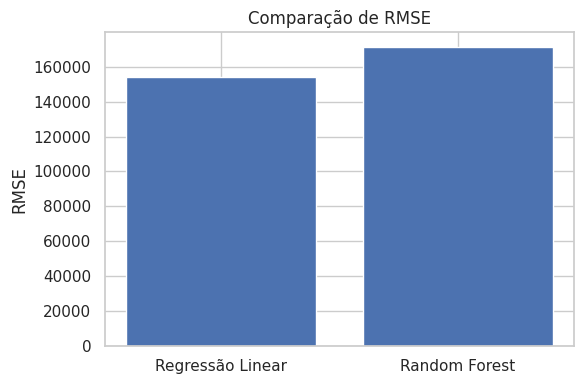

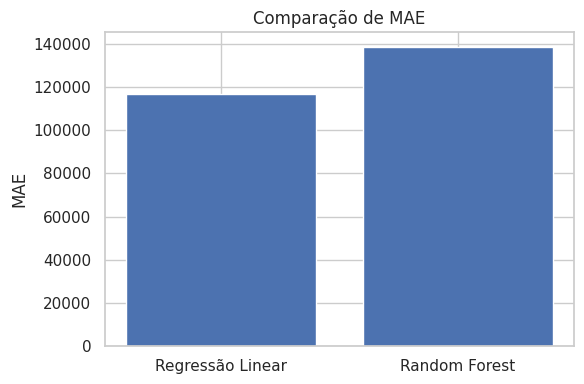

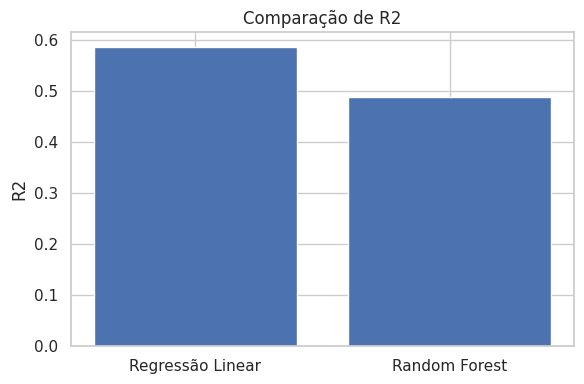

In [218]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1. Preparação dos dados e split
features = [
    'Capacidade Total',
    '1.3 Capacidade do estabelecimento | Regime fechado | Total',
    '1.3 Capacidade do estabelecimento | Regime semiaberto | Total',
    '1.3 Capacidade do estabelecimento | Regime aberto | Total'
]
X = df_brasil_ano[features]
y = df_brasil_ano['5.1 Quantidade de pessoas privadas de liberdade por faixa etária | Total']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=10
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# 2. Regressão Linear
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

mse_lr  = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
mae_lr  = mean_absolute_error(y_test, y_pred_lr)
r2_lr   = r2_score(y_test, y_pred_lr)

# 3. Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=10)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)

mse_rf  = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
mae_rf  = mean_absolute_error(y_test, y_pred_rf)
r2_rf   = r2_score(y_test, y_pred_rf)

# 4. Tabela de comparação
df_comp = pd.DataFrame({
    'Modelo': ['Regressão Linear', 'Random Forest'],
    'RMSE':   [rmse_lr, rmse_rf],
    'MAE':    [mae_lr,  mae_rf],
    'R2':     [r2_lr,   r2_rf]
})
print(df_comp)

# 5. Gráficos comparativos
for metric in ['RMSE', 'MAE', 'R2']:
    plt.figure(figsize=(6,4))
    plt.bar(df_comp['Modelo'], df_comp[metric])
    plt.title(f'Comparação de {metric}')
    plt.ylabel(metric)
    plt.tight_layout()
    plt.show()


In [219]:
from scipy import stats

def intervalo_confiança_media(preds, alfa=0.05):
    n       = len(preds)
    media   = np.mean(preds)
    sem     = stats.sem(preds)
    t_crit  = stats.t.ppf(1 - alfa/2, df=n-1)
    margem  = t_crit * sem
    return media - margem, media + margem

ic_lr_inf, ic_lr_sup   = intervalo_confiança_media(y_pred_lr)
ic_rf_inf, ic_rf_sup   = intervalo_confiança_media(y_pred_rf)

print("Intervalo de Confiança (95%) para a média das previsões:")
print(f"  • Regressão Linear:      ({ic_lr_inf:,.0f}, {ic_lr_sup:,.0f})")
print(f"  • Random Forest:         ({ic_rf_inf:,.0f}, {ic_rf_sup:,.0f})")

Intervalo de Confiança (95%) para a média das previsões:
  • Regressão Linear:      (-402,469, 3,118,605)
  • Random Forest:         (96,620, 2,651,945)


**Interpretação dos Resultados da Regressão Linear**

**RMSE (Erro Médio Quadrado) = 154 073,31**

Indica que, em média, as previsões do modelo erram cerca de 154 000 pessoas privativas de liberdade, penalizando grandes erros.

**MAE (Erro Médio Absoluto) = 116 718,06**

Mostra que sem penalização extra para grandes desvios o erro médio absoluto das previsões é de aproximadamente 117 000 pessoas.

**R² (Coeficiente de Determinação) = 0,5849**

Mostra que cerca de 58,5 % da variabilidade observada na população carcerária anual é explicada pelas variáveis de capacidade prisional.

**Intervalo de Confiança (95 %) para a média das previsões = (–402 468,90; 3 118 604,78)**

Esse intervalo é extremamente amplo e inclui valores absurdos, inclusive negativo, que sugere:

- Alta variabilidade nas previsões do modelo.

- Pouca precisão, indicando que, se repetíssemos esse processo em outro conjunto de dados semelhante, teríamos médias de previsão muito diferentes.

**Conclusão**

É possível prever o número de pessoas privadas de liberdade em um estado nos próximos anos a partir do histórico da população carcerária e da disponibilidade de vagas no sistema prisional?

Resposta: Sim, há sinal estatístico consistente de que a capacidade prisional (vagas disponíveis) explica parte (≈58,5%) da variação anual da população carcerária, e uma regressão linear consegue gerar previsões estruturadas nesse histórico.

Limitações:

 - Margem de erro elevada (MAE >100000), insuficiente para previsões de alta precisão.

 - Intervalo de confiança extremamente amplo, indicando baixa robustez estatística das estimativas pontuais.

 - Fatores externos não considerados (políticas de encarceramento, dinâmica criminal, variações socioeconômicas).

## Pergunta 2

**É possível relacionar a quantidade de óbitos naturais/por motivos de saúde com a qualidade da área médica das prisões?**

- Limpeza e estruturação dos dados  


Primeiramente, a colunas de população prisional total foi transformada em numérica. A seguir, foi feita as montagems do grupo de colunas que diz respeito a estrutura hospitalar e do grupo de colunas da quantidade dos profissionais da área médica e de enfermagem presentes. Depois disso, foi calculado um "score" para cada prisão fazendo a soma total das estruturas e profissionais presentes dividido pelo número de presos. Por fim, foi feito a transformação da coluna de óbitos por motivos de saúde/naturais em numérica.

In [220]:
dfp2 = dados.copy()
dfp2.columns = dfp2.columns.str.strip()

dfp2['populacao_total'] = pd.to_numeric(dfp2['4.1 População prisional | Total'], errors='coerce')

#Montagem da coluna de estrutura hospitalar
colunas_estrutura = [col for col in dfp2.columns if col.startswith('2.4')]
dfp2[colunas_estrutura] = dfp2[colunas_estrutura].replace({'Sim': 1, 'Não': 0})
dfp2[colunas_estrutura] = dfp2[colunas_estrutura].apply(pd.to_numeric, errors='coerce')

dfp2['total_estrutura_saude'] = dfp2[colunas_estrutura].sum(axis=1)

#Montagem da coluna de profissionais da saúde
profissionais_prefixos = [
    '3.1 Quantidade de Servidores que atuam no Sistema Prisional | Médicos - clínicos gerais',
    '3.1 Quantidade de Servidores que atuam no Sistema Prisional | Médicos - ginecologistas',
    '3.1 Quantidade de Servidores que atuam no Sistema Prisional | Médicos - psiquiatras',
    '3.1 Quantidade de Servidores que atuam no Sistema Prisional | Médicos - outras especialidades',
    '3.1 Quantidade de Servidores que atuam no Sistema Prisional | Auxiliar e técnico de enfermagem',
    '3.1 Quantidade de Servidores que atuam no Sistema Prisional | Enfermeiros'
]

colunas_profissionais = [col for col in dfp2.columns if any(prof in col for prof in profissionais_prefixos)]
dfp2[colunas_profissionais] = dfp2[colunas_profissionais].apply(pd.to_numeric, errors='coerce')

#Cálculo do score de qualidade em saúde
dfp2['total_profissionais_saude'] = dfp2[colunas_profissionais].sum(axis=1)
dfp2['score_qualidade_saude'] = (dfp2['total_estrutura_saude'] + dfp2['total_profissionais_saude']) / (dfp2['4.1 População prisional | Total'])

dfp2['obitos_doenca'] = pd.to_numeric(dfp2['6.8 Mortalidade no Sistema Prisional (total do período) | Óbitos naturais/ óbitos por motivos de saúde | Total'], errors='coerce')
dfp2 = dfp2.dropna(subset=['score_qualidade_saude', 'obitos_doenca'])

/tmp/ipython-input-220-3146665494.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dfp2[colunas_estrutura] = dfp2[colunas_estrutura].replace({'Sim': 1, 'Não': 0})
/tmp/ipython-input-220-3146665494.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dfp2['total_profissionais_saude'] = dfp2[colunas_profissionais].sum(axis=1)
/tmp/ipython-input-220-3146665494.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining a

- Cálculo da correlação utilizando spearman

In [221]:
cor, p_valor = spearmanr(dfp2['score_qualidade_saude'], dfp2['obitos_doenca'])
print("Correlação (Spearman):", cor)
print("Valor-p:", p_valor)

Correlação (Spearman): -0.206389751318159
Valor-p: 1.3352733497468027e-160


- Gráficos para demonstração

Dispersão

/usr/local/lib/python3.11/dist-packages/numpy/_core/function_base.py:168: RuntimeWarning: invalid value encountered in multiply
  y *= step
/usr/local/lib/python3.11/dist-packages/numpy/lib/_nanfunctions_impl.py:1634: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:4779: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


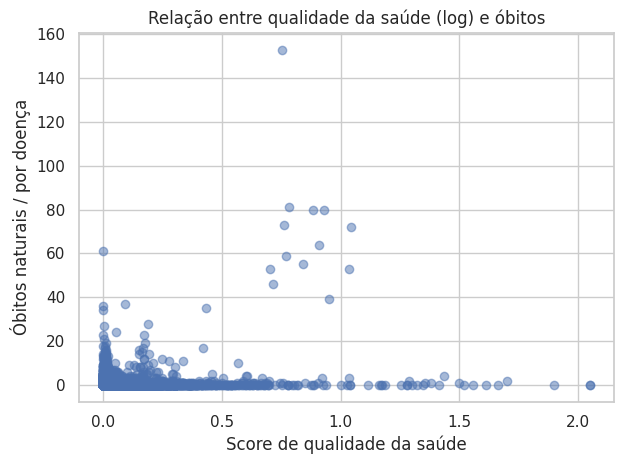

In [222]:
dfp2_plot = dfp2.copy()
dfp2_plot['score_qualidade_saude'] = np.log10(dfp2['score_qualidade_saude'] + 1)

sns.regplot(
    x='score_qualidade_saude',
    y='obitos_doenca',
    data=dfp2_plot,
    scatter_kws={'alpha': 0.5},
    line_kws={'color': 'green'}
)

plt.xlabel('Score de qualidade da saúde')
plt.ylabel('Óbitos naturais / por doença')
plt.title('Relação entre qualidade da saúde (log) e óbitos')
plt.grid(True)
plt.tight_layout()
plt.show()

Boxplot comparando Scores de qualidade hospitalar

/tmp/ipython-input-223-1427446063.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dfp2['Grupo Qualidade'] = ['Baixa' if x <= mediana else 'Alta' for x in dfp2_plot['score_qualidade_saude']]
/tmp/ipython-input-223-1427446063.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Grupo Qualidade', y='obitos_doenca', data=dfp2, palette='Set2')


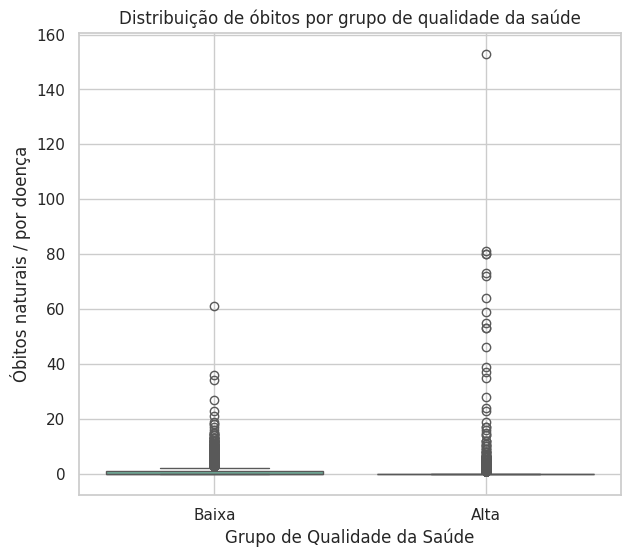

In [223]:
mediana = dfp2_plot['score_qualidade_saude'].median()
dfp2['Grupo Qualidade'] = ['Baixa' if x <= mediana else 'Alta' for x in dfp2_plot['score_qualidade_saude']]

plt.figure(figsize=(7, 6))
sns.boxplot(x='Grupo Qualidade', y='obitos_doenca', data=dfp2, palette='Set2')
plt.title('Distribuição de óbitos por grupo de qualidade da saúde')
plt.xlabel('Grupo de Qualidade da Saúde')
plt.ylabel('Óbitos naturais / por doença')
plt.grid(True)
plt.show()

**Testes de hipóteses**

Hipóteses:
H0 (Hipótese nula): Não há diferença significativa entre a média de óbitos em prisões com baixa e alta qualidade médica.

H1 (Hipótese alternativa): Há diferença significativa entre as médias de óbitos em prisões com baixa e alta qualidade médica.

In [224]:
dfp2_test = dfp2.dropna(subset=['score_qualidade_saude', 'obitos_doenca']).copy()

# Dividir grupos por mediana do índice
mediana = dfp2_test['score_qualidade_saude'].median()
grupo_baixo = dfp2_test[dfp2_test['score_qualidade_saude'] <= mediana]['obitos_doenca']
grupo_alto = dfp2_test[dfp2_test['score_qualidade_saude'] > mediana]['obitos_doenca']

# Teste t de duas amostras independentes (amostras não pareadas)
t_stat, p_val = stats.ttest_ind(grupo_baixo, grupo_alto, equal_var=False)

print("Estatística do teste t:", t_stat)
print("Valor-p:", p_val)

if p_val < 0.05:
    print("Rejeitamos a hipótese nula: há diferença significativa nos óbitos entre prisões com qualidade médica alta e baixa.")
else:
    print("Não rejeitamos a hipótese nula: não há evidência significativa de diferença entre os grupos.")

Estatística do teste t: 11.948380638336051
Valor-p: 9.603743677247455e-33
Rejeitamos a hipótese nula: há diferença significativa nos óbitos entre prisões com qualidade médica alta e baixa.


In [225]:
def intervalo_confianca(dados, nivel=0.95):
    n = len(dados)
    media = np.mean(dados)
    erro = stats.sem(dados)
    margem = erro * stats.t.ppf((1 + nivel) / 2., n-1)
    return media - margem, media + margem

# Intervalos de confiança para os dois grupos
ic_baixo = intervalo_confianca(grupo_baixo)
ic_alto = intervalo_confianca(grupo_alto)

print(f"\nIntervalo de confiança (95%) para a média de óbitos - Qualidade BAIXA: {ic_baixo}")
print(f"Intervalo de confiança (95%) para a média de óbitos - Qualidade ALTA:  {ic_alto}")


Intervalo de confiança (95%) para a média de óbitos - Qualidade BAIXA: (np.float64(0.9051677230568415), np.float64(0.9873952469801647))
Intervalo de confiança (95%) para a média de óbitos - Qualidade ALTA:  (np.float64(0.39470033949440064), np.float64(0.5304518629647136))


Foi analisada a relação entre a qualidade da saúde prisional e a quantidade de óbitos por causas naturais ou de saúde. Para isso, foi criado um score que combina infraestrutura médica e número de profissionais da saúde, normalizado pela população prisional de cada unidade.

Aplicou-se o teste de spearman, considerando como hipótese nula a inexistência de associação. O resultado de correlação de -0,206, com valor-p ≈ 0, indicou correlação negativa estatisticamente significante entre os fatores.

Com isso, observou-se que unidades prisionais com melhor estrutura e maior número de profissionais de saúde por preso tendem a registrar menos óbitos por causas naturais ou de saúde. No entanto, não é possível afirmar causalidade com certeza, pois outros fatores, como a idade média da população custodiada, não foram incluidos no estudo e podem influenciar os resultados.

## Pergunta 3

**Existe uma correlação entre a oferta de serviços de assistência social nas unidades prisionais com o percentual de presos que trabalham e/ou estudam?**



**Limpeza e estruturação dos dados**

Aqui foram selecionadas as colunas de interessa para responder a pergunta.

Os serviços de assistência social ofertados foram separados em três módulos temáticos: saúde, educação e oficinas (atividades de natureza técnica laboral).



In [226]:
# Filtragem das colunas
colunas_identificacao = [
    'ID',
    'Referência',
]

dados_filtrados3 = dados_filtrados[colunas_identificacao].copy()

# Colunas sobre a população carcerária
coluna_populacao_prisional = ['4.1 População prisional | Total']

dados_filtrados3['Populacao_Prisional'] = dados_filtrados['4.1 População prisional | Total']

total_presos_trabalham = [
    '6.1 Quantidade de pessoas privadas de liberdade em programas de laborterapia | Trabalho externo Masculino',
    '6.1 Quantidade de pessoas privadas de liberdade em programas de laborterapia | Trabalho externo Feminino',
    '6.1 Quantidade de pessoas privadas de liberdade em programas de laborterapia | Trabalho interno Masculino',
    '6.1 Quantidade de pessoas privadas de liberdade em programas de laborterapia | Trabalho interno Feminino'
]

total_presos_estudam = [
    '6.3 Quantidade de pessoas privadas de liberdade em atividade educacional | Alfabetização | Total',
    '6.3 Quantidade de pessoas privadas de liberdade em atividade educacional | Ensino Fundamental | Total',
    '6.3 Quantidade de pessoas privadas de liberdade em atividade educacional | Ensino Médio | Total',
    '6.3 Quantidade de pessoas privadas de liberdade em atividade educacional | Ensino Superior | Total',
    '6.3 Quantidade de pessoas privadas de liberdade em atividade educacional | Curso Técnico (acima de 800 horas de aula) | Total',
    '6.3 Quantidade de pessoas privadas de liberdade em atividade educacional | Curso de Formação Inicial e Continuada (Capacitação Profissional, acima de 160 horas de aula) | Total'
]

total_presos_trabalham_estudam = [
    '6.4 Quantidade de pessoas trabalhando e estudando, simultaneamente | Pessoas que trabalham e estudam | Masculino',
    '6.4 Quantidade de pessoas trabalhando e estudando, simultaneamente | Pessoas que trabalham e estudam | Feminino'
]

# Colunas sobre a infraestrutura dos presídios
colunas_modulo_saude = [
    '2.4 Módulo de saúde | Consultório médico | Quantidade',
    '2.4 Módulo de saúde | Consultório odontológico | Quantidade',
    '2.4 Módulo de saúde | Sala de coleta de material para laboratório | Quantidade',
    '2.4 Módulo de saúde | Sala de curativos, suturas, vacinas e posto de enfermagem | Quantidade',
    '2.4 Módulo de saúde | Cela de observação | Quantidade',
    '2.4 Módulo de saúde | Cela de enfermaria com solário | Quantidade',
    '2.4 Módulo de saúde | Sanitário para pacientes | Quantidade',
    '2.4 Módulo de saúde | Sanitários para equipe de saúde | Quantidade',
    '2.4 Módulo de saúde | Farmácia ou sala de estoque/ dispensação de medicamentos | Quantidade',
    '2.4 Módulo de saúde | Central de material esterilizado/ expurgo | Quantidade',
    '2.4 Módulo de saúde | Sala de lavagem e descontaminação | Quantidade',
    '2.4 Módulo de saúde | Sala de esterilização | Quantidade',
    '2.4 Módulo de saúde | Vestiário | Quantidade',
    '2.4 Módulo de saúde | Depósito de material de limpeza - DML | Quantidade',
    '2.4 Módulo de saúde | Sala de atendimento clínico multiprofissional | Quantidade',
    '2.4 Módulo de saúde | Sala de procedimentos | Quantidade',
    '2.4 Módulo de saúde | Sala de raio x | Quantidade',
    '2.4 Módulo de saúde | Laboratório de diagnóstico | Quantidade',
    '2.4 Módulo de saúde | Cela de espera | Quantidade',
    '2.4 Módulo de saúde | Solário para pacientes | Quantidade',
    '2.4 Módulo de saúde | Outro(s). Qual(is)? | Quantidade',
]

colunas_modulo_educacao = [
    '2.5 Módulo de educação | Sala de aula | Quantidade de salas',
    '2.5 Módulo de educação | Sala de informática | Quantidade de salas',
    '2.5 Módulo de educação | Sala de encontros com a sociedade/ sala de reuniões | Quantidade de salas',
    '2.5 Módulo de educação | Biblioteca | Quantidade de salas',
    '2.5 Módulo de educação | Sala de professores | Quantidade de salas',
    '2.5 Módulo de educação | Outro(s). Qual(is)? | Quantidade de salas',
]

colunas_modulo_oficinas = [
    '2.5.1 Há local específico para biblioteca?',
    '2.6 Módulo de oficinas | Sala de produção',
    '2.6 Módulo de oficinas | Sala de controle/ supervisão',
    '2.6 Módulo de oficinas | Sanitários',
    '2.6 Módulo de oficinas | Estoque',
    '2.6 Módulo de oficinas | Carga/ descarga',
    '2.6 Módulo de oficinas | Artefatos de concreto',
    '2.6 Módulo de oficinas | Blocos e tijolos',
    '2.6 Módulo de oficinas | Padaria e panificação',
    '2.6 Módulo de oficinas | Corte e costura industrial',
    '2.6 Módulo de oficinas | Artesanato',
    '2.6 Módulo de oficinas | Marcenaria',
    '2.6 Módulo de oficinas | Serralheria',
]

colunas_interesse = colunas_identificacao + coluna_populacao_prisional + colunas_modulo_saude + colunas_modulo_oficinas + colunas_modulo_educacao + total_presos_trabalham + total_presos_estudam + total_presos_trabalham_estudam

As perguntas dos módulos 2.5.1 e 2.6 foram respondidas com 'Sim' ou 'Não' a fim de indicar a presença ou ausência das respectivas oficinas nas unidades prisionais.
Como a intenção aqui era fazer uma análise quantitativa e somar a quantidade de módulos em cada unidade, as respostas nominais foram transformadas em númericas para que isso fosse possível ('Sim' = 1  e 'Não' = 0).

Ter o valor = 1 significará, portanto, que existe pelo menos um módulo dessa oficina no presídio e esse valor será somado a quantidade total de módulos da respectiva unidade prisional.

In [227]:
# Atualização dos dados
dados_3 = dados_filtrados[colunas_interesse].replace({
    np.nan: '0.0',
    'Sim': '1.0',
    'Não': '0.0'
}, regex=True)

# Renomeação da coluna 4.1
dados_3 = dados_3.rename(columns={'4.1 População prisional | Total': 'Populacao_Prisional'})

# Soma das colunas agrupadas em três módulos
dados_filtrados3['Total_Modulo_Saude'] = dados_3[colunas_modulo_saude].astype(float).sum(axis=1)
dados_filtrados3['Total_Modulo_Educacao'] = dados_3[colunas_modulo_educacao].astype(float).sum(axis=1)
dados_filtrados3['Total_Modulo_Oficinas'] = dados_3[colunas_modulo_oficinas].astype(float).sum(axis=1)

dados_filtrados3['Total_Presos_Empregados'] = dados_3[total_presos_trabalham].astype(float).sum(axis=1)
dados_filtrados3['Total_Presos_Estudantes'] = dados_3[total_presos_estudam].astype(float).sum(axis=1)
dados_filtrados3['Total_Presos_Empregados_Estudantes'] = dados_3[total_presos_trabalham_estudam].astype(float).sum(axis=1)

# Cálculo da taxa ocupacional em cada presídio
dados_filtrados3['Taxa_Ocupacao'] = ((dados_filtrados3['Total_Presos_Empregados'] + dados_filtrados3['Total_Presos_Estudantes'] + dados_filtrados3['Total_Presos_Empregados_Estudantes']) / dados_filtrados3['Populacao_Prisional'].astype(float)) * 100

colunas_filtradas = ['ID',
  'Referência',
  'Total_Modulo_Saude',
  'Total_Modulo_Educacao',
  'Total_Modulo_Oficinas',
  'Populacao_Prisional',
  'Total_Presos_Empregados',
  'Total_Presos_Estudantes',
  'Total_Presos_Empregados_Estudantes',
  'Taxa_Ocupacao']

dados_filtrados3 = dados_filtrados3[colunas_filtradas]

dados_filtrados3.head(10)

,ID,Referência,Total_Modulo_Saude,Total_Modulo_Educacao,Total_Modulo_Oficinas,Populacao_Prisional,Total_Presos_Empregados,Total_Presos_Estudantes,Total_Presos_Empregados_Estudantes,Taxa_Ocupacao
0,4410.0,2024/2,0.0,0.0,0.0,199,0.0,0.0,9.0,4.522613
1,5570.0,2024/2,0.0,0.0,0.0,173,162.0,0.0,0.0,93.641618
2,3581.0,2024/2,0.0,0.0,0.0,327,0.0,0.0,0.0,0.000000
3,3579.0,2024/2,0.0,0.0,0.0,350,0.0,0.0,0.0,0.000000
4,1841.0,2024/2,0.0,0.0,0.0,1670,0.0,0.0,0.0,0.000000
5,31.0,2024/2,25.0,0.0,0.0,1724,1409.0,248.0,0.0,96.113689
6,35.0,2024/2,7.0,5.0,6.0,169,161.0,128.0,0.0,171.005917
7,34.0,2024/2,0.0,9.0,1.0,1159,1059.0,259.0,2.0,113.891286
8,33.0,2024/2,0.0,2.0,1.0,86,0.0,0.0,0.0,0.000000
9,39.0,2024/2,0.0,0.0,0.0,25,0.0,0.0,0.0,0.000000


In [228]:
print(len(dados_filtrados3[dados_filtrados3['Taxa_Ocupacao'] > 100]))


3782


Nota-se, com o resultado acima, a presença de registros com valores de taxa de ocupação que superam a lotação máxima do presídio, o que é um forte indicativo de que há presídios com superlotação. Pensando por essa linha de raciocínio, foi decidido não tratar esses valores como outliers e preservá-los na análise.





*   Estatísticas



In [229]:
dados_filtrados3.describe()

,ID,Total_Modulo_Saude,Total_Modulo_Educacao,Total_Modulo_Oficinas,Populacao_Prisional,Total_Presos_Empregados,Total_Presos_Estudantes,Total_Presos_Empregados_Estudantes,Taxa_Ocupacao
count,25738.000000,25738.000000,25738.000000,25738.000000,25738.000000,25738.000000,25738.000000,25738.000000,25737.000000
mean,1382.663727,7.828619,3.565662,2.064574,519.664970,93.984614,71.235566,13.967946,59.214313
std,1391.369355,11.078454,4.372198,2.644001,1107.806943,169.346838,155.234939,55.228803,602.260100
min,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,545.000000,0.000000,0.000000,0.000000,80.000000,3.000000,0.000000,0.000000,6.611570
50%,986.000000,4.000000,2.000000,1.000000,192.000000,34.000000,16.000000,0.000000,29.640719
75%,1404.000000,12.000000,6.000000,3.000000,640.000000,105.000000,80.000000,5.000000,67.567568
max,7369.000000,218.000000,183.000000,13.000000,42535.000000,2604.000000,3683.000000,1749.000000,68200.000000


O gráfico abaixo apresenta a evolução da média os módulos de interesse ao longo dos semestres. Para isso, utilizou-se o método lineplot() da biblioteca Seaborn, que plota a média dos valores de cada categoria em função do tempo e inclui intervalos de confiança padronizados de 95%.



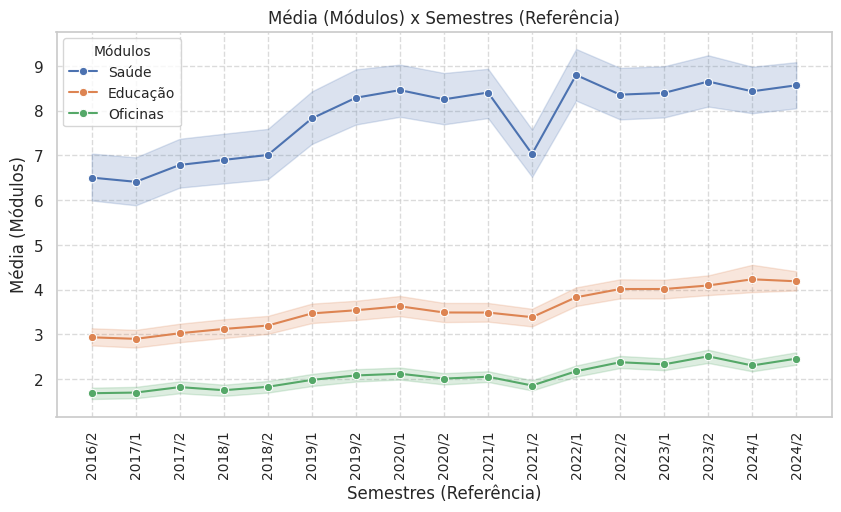

In [230]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))

# Inverter os eixos
dados_filtrados3 = dados_filtrados3.iloc[::-1].reset_index(drop=True)

sns.lineplot(x=dados_filtrados3['Referência'], y=dados_filtrados3['Total_Modulo_Saude'], marker='o', label='Saúde')
sns.lineplot(x=dados_filtrados3['Referência'], y=dados_filtrados3['Total_Modulo_Educacao'], marker='o', label='Educação')
sns.lineplot(x=dados_filtrados3['Referência'], y=dados_filtrados3['Total_Modulo_Oficinas'], marker='o', label='Oficinas')

plt.title('Média (Módulos) x Semestres (Referência)', fontsize=12)
plt.xlabel('Semestres (Referência)', fontsize=12)
plt.ylabel('Média (Módulos)', fontsize=12)

plt.xticks(rotation=90, ha='center', fontsize=10)

plt.legend(title='Módulos', fontsize=10, title_fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

**Testes de hipóteses**

H₀ (hipótese nula): Não existe correlação entre a oferta de serviços de assistência social e o percentual de presos que trabalham/estudam.

H₁ (hipótese alternativa): Existe correlação entre a oferta de serviços de assistência social e o percentual de presos que trabalham/estudam.

In [231]:
dados_percentuais = pd.DataFrame()

# Calcular o percentual de atividade
dados_percentuais['Percentual_Atividade'] = (
    dados_filtrados3['Total_Presos_Empregados_Estudantes'] / dados_filtrados3['Populacao_Prisional']
) * 100

# Calcular a oferta de assistência social como média dos módulos
dados_percentuais['Oferta_Assistencia_Social'] = dados_filtrados3[['Total_Modulo_Saude', 'Total_Modulo_Educacao', 'Total_Modulo_Oficinas']].mean(axis=1)

# Verificar se há linhas totalmente nulas
print(dados_percentuais[['Oferta_Assistencia_Social', 'Percentual_Atividade']].isnull().sum())


Oferta_Assistencia_Social    0
Percentual_Atividade         1
dtype: int64


In [232]:
# Remoção de linhas totalmente nulas
dados_limpos = dados_percentuais.dropna(subset=['Oferta_Assistencia_Social', 'Percentual_Atividade'])

In [233]:
dados_limpos[['Oferta_Assistencia_Social', 'Percentual_Atividade']].describe()


,Oferta_Assistencia_Social,Percentual_Atividade
count,25737.000000,25737.000000
mean,4.486459,5.096329
std,5.054739,31.091503
min,0.000000,0.000000
25%,0.666667,0.000000
50%,3.000000,0.000000
75%,7.000000,2.222222
max,75.666667,4000.000000


In [234]:
from scipy.stats import spearmanr

resultados_correlacao = []

for _ in range(1000):
    resultado_3 = dados_limpos.sample(frac=1, replace=True)
    corr, p_val = spearmanr(resultado_3['Oferta_Assistencia_Social'], resultado_3['Percentual_Atividade'])
    resultados_correlacao.append(corr)

# Intervalo de confiança de 95%
limite_inferior = np.percentile(resultados_correlacao, 2.5)
limite_superior = np.percentile(resultados_correlacao, 97.5)

print("Coeficiente de correlação de Pearson:", corr)
print(f"Intervalo de confiança 95%: [{limite_inferior:.3f}, {limite_superior:.3f}]")
print("Valor-p:", p_val)

if p_val < 0.05:
    print("Rejeitamos H0: há correlação significativa.")
else:
    print("Não rejeitamos H0: não há evidência de correlação significativa.")

Coeficiente de correlação de Pearson: 0.21422228802528162
Intervalo de confiança 95%: [0.221, 0.244]
Valor-p: 6.942606528360554e-265
Rejeitamos H0: há correlação significativa.


Com finalidade de investir uma correlação existente entre a oferta de serviços de assistência social nas unidades prisionais e a proporção de detentos envolvidos em atividades de trabalho e/ou estudo, criou-se variável que representa a média da disponibilidade dos módulos ofertados em cada unidade prisional e calculou-se o percentual de presos participantes dessas atividades em relação à população total de cada unidade.

Para avaliar essa relação, utilizou-se Spearman, tendo como hipótese nula a ausência de associação entre as variáveis analisadas.

O teste apontou uma correlação positiva de, aproximadamente, 0,23, com valor-p muito próximo de zero. Apesar de fraca, há uma relação estatisticamente significativa entre a oferta de serviços e a participação dos presos em atividades laborais e/ou educacionais.

Os dados sugerem, portanto, que unidades com maior estrutura de serviços assistenciais tendem a apresentar proporções mais altas de presos trabalhando ou estudando.

**Regressão linear**

In [235]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# Definição das variáveis
X = dados_filtrados3[['Total_Modulo_Saude', 'Total_Modulo_Educacao', 'Total_Modulo_Oficinas']]
y = dados_filtrados3['Taxa_Ocupacao']




## Pergunta 4
**Existe uma correlação entre os grupos de crime pelos quais os detentos foram condenados e a incidência de óbitos prisionais de natureza criminal?**


**Fluxo de trabalho**
1. Análise Exploratória  
- Limpeza e estruturação dos dados:   
  - Espaços em branco foram convertidos para NaN, garantindo a integridade na leitura e manipulação dos dados

  - Colunas com mais de 75% de valores ausentes foram removidas

  - Os valores NaN restantes foram preenchidos com zero, assumindo ausência do evento/crime na unidade correspondente;

  - As variáveis foram convertidas em proporções relativas à população prisional de cada unidade

  - Crimes foram agrupados em categorias conforme o formulário de coleta

  - Grupos com soma acumulada igual a zero foram removidos

- Visualização da representatividade dos grupos de crimes por meio do uso de Treemap para visualizar a proporção de cada grupo de crime por preso

- Distribuição individual para cada grupo de crime por meio de Histogramas

- Identificação de outliers

- Distribuição dos óbitos criminais por meio de Histogramas

2. Testes de Hipótese
- Formulação de hipóteses
  - **H₀ (Hipótese nula):** Não existe correlação entre os grupos de crimes e os óbitos criminais.
  - **H₁ (Hipótese alternativa):** Existe correlação entre os grupos de crimes e os óbitos criminais.

- Cálculo das correlações de Spearman entre proporções de crimes e óbitos criminais

- Cálculo dos intervalos de confiança por meio de bootstrap

3. Modelagem com Machine Learning
- Tratamento de dados (definição dos dados de entrada, variável-alvo, tratamento de valores ausentes, transformação utilizada e normalização)

- Treinamento e avaliação do modelo (Random Forest com R^2 score e MAE)


**Limpeza e estruturação dos dados**  
Inicialmente, selecionamos as variáveis relevantes: número de detentos por tipo penal, total de óbitos criminais por unidade e população prisional total. Para garantir a integridade, espaços em branco foram convertidos para valores ausentes (NaN).

In [236]:
coluna_populacao_prisional = ['4.1 População prisional | Total']

# Coluna com a variável-alvo: óbitos criminais
mortalidade_criminal = [
    '6.8 Mortalidade no Sistema Prisional (total do período) | Óbitos criminais | Total'
]

# Palavra-chave para identificar colunas com incidência de crimes
crimes = [
    '5.14 Quantidade de incidências por tipo penal'
]

# Seleciona apenas as colunas de crimes totais por tipo penal
colunas_crimes = [
    col for col in dados_filtrados.columns
    if '5.14' in col and 'Total' in col and any(tipo in col for tipo in crimes)
]

# Seleciona apenas as colunas relevantes: crimes, óbitos e população prisional
colunas_selecionadas = colunas_crimes + mortalidade_criminal + coluna_populacao_prisional
df_crimes_obitos = dados_filtrados[colunas_selecionadas]

# Substitui espaços em branco por NaN para normalizar os dados ausentes
df_crimes_obitos = df_crimes_obitos.replace(r'^\s*$', np.nan, regex=True)

Em seguida, realizamos a renomeação das colunas, com o objetivo de facilitar a leitura e a identificação dos grupos aos quais cada tipo de crime pertence.

In [237]:
# Renomeação das colunas
df_crimes_obitos = df_crimes_obitos.rename(columns={
    '5.14 Quantidade de incidências por tipo penal |  GRUPO: CÓDIGO PENAL | Grupo: Crimes contra a pessoa | Homicídio simples (Art. 121, caput) | Total': 'Pessoa_Homicidio_Simples',
    '5.14 Quantidade de incidências por tipo penal |  GRUPO: CÓDIGO PENAL | Grupo: Crimes contra a pessoa | Homicílio culposo (Art. 121, § 3°) | Total': 'Pessoa_Homicidio_Culposo',
    '5.14 Quantidade de incidências por tipo penal |  GRUPO: CÓDIGO PENAL | Grupo: Crimes contra a pessoa | Homicídio qualificado (Art. 121, § 2°) | Total': 'Pessoa_Homicidio_Qualificado',
    '5.14 Quantidade de incidências por tipo penal |  GRUPO: CÓDIGO PENAL | Grupo: Crimes contra a pessoa | Aborto (Art. 124, 125, 126 e 127) | Total': 'Pessoa_Aborto',
    '5.14 Quantidade de incidências por tipo penal |  GRUPO: CÓDIGO PENAL | Grupo: Crimes contra a pessoa | Lesão corporal (Art. 129, caput e § 1°, 2°, 3° e 6°) | Total': 'Pessoa_Lesao_Corporal',
    '5.14 Quantidade de incidências por tipo penal |  GRUPO: CÓDIGO PENAL | Grupo: Crimes contra a pessoa | Violência doméstica (Art. 129,  § 9°) | Total': 'Pessoa_Violencia_Domestica',
    '5.14 Quantidade de incidências por tipo penal |  GRUPO: CÓDIGO PENAL | Grupo: Crimes contra a pessoa | Sequestro e cárcere privado (Art. 148) | Total': 'Pessoa_Sequestro_Carcere',
    '5.14 Quantidade de incidências por tipo penal |  GRUPO: CÓDIGO PENAL | Grupo: Crimes contra a pessoa | Outros - não listados acima entre os artigos 122 e 154-A | Total': 'Pessoa_Outros_122_154A',

    '5.14 Quantidade de incidências por tipo penal |  GRUPO: CÓDIGO PENAL | Grupo: Crimes contra o patrimônio | Furto simples (Art. 155) | Total': 'Patrimonio_Furto_Simples',
    '5.14 Quantidade de incidências por tipo penal |  GRUPO: CÓDIGO PENAL | Grupo: Crimes contra o patrimônio | Furto qualificado (Art. 155, § 4° e 5°) | Total': 'Patrimonio_Furto_Qualificado',
    '5.14 Quantidade de incidências por tipo penal |  GRUPO: CÓDIGO PENAL | Grupo: Crimes contra o patrimônio | Roubo simples (Art. 157) | Total': 'Patrimonio_Roubo_Simples',
    '5.14 Quantidade de incidências por tipo penal |  GRUPO: CÓDIGO PENAL | Grupo: Crimes contra o patrimônio | Roubo qualificado (Art. 157, § 2° | Total': 'Patrimonio_Roubo_Qualificado',

    '5.14 Quantidade de incidências por tipo penal |  GRUPO: CÓDIGO PENAL | Grupo: Crimes contra o patrimônio | Latrocínio (Art. 157, § 3°) | Total': 'Patrimonio_Latrocinio',
    '5.14 Quantidade de incidências por tipo penal |  GRUPO: CÓDIGO PENAL | Grupo: Crimes contra o patrimônio | Extorsão (Art. 158) | Total': 'Patrimonio_Extorsao',
    '5.14 Quantidade de incidências por tipo penal |  GRUPO: CÓDIGO PENAL | Grupo: Crimes contra o patrimônio | Extorsão mediante sequestro (Art. 159) | Total': 'Patrimonio_Extorsao_Sequestro',
    '5.14 Quantidade de incidências por tipo penal |  GRUPO: CÓDIGO PENAL | Grupo: Crimes contra o patrimônio | Apropriação indébita (Art. 168) | Total': 'Patrimonio_Apropriacao_Indebita',
    '5.14 Quantidade de incidências por tipo penal |  GRUPO: CÓDIGO PENAL | Grupo: Crimes contra o patrimônio | Apropriação indébita previdenciária (Art. 168-A) | Total': 'Patrimonio_Apropriacao_Previdenciaria',
    '5.14 Quantidade de incidências por tipo penal |  GRUPO: CÓDIGO PENAL | Grupo: Crimes contra o patrimônio | Estelionato (Art. 171) | Total': 'Patrimonio_Estelionato',
    '5.14 Quantidade de incidências por tipo penal |  GRUPO: CÓDIGO PENAL | Grupo: Crimes contra o patrimônio | Receptação (Art. 180) | Total': 'Patrimonio_Receptacao',
    '5.14 Quantidade de incidências por tipo penal |  GRUPO: CÓDIGO PENAL | Grupo: Crimes contra o patrimônio | Receptação qualificada (Art. 180, § 1°) | Total': 'Patrimonio_Receptacao_Qualificada',
    '5.14 Quantidade de incidências por tipo penal |  GRUPO: CÓDIGO PENAL | Grupo: Crimes contra o patrimônio | Outros - não listados acima entre os artigos 156 e 179 | Total': 'Patrimonio_Outros_156_179',

    '5.14 Quantidade de incidências por tipo penal |  GRUPO: CÓDIGO PENAL | Grupo: Crimes contra a dignidade sexual | Estupro (Art. 213) | Total': 'Sexual_Estupro',
    '5.14 Quantidade de incidências por tipo penal |  GRUPO: CÓDIGO PENAL | Grupo: Crimes contra a dignidade sexual | Atentado violento ao pudor (Art. 214) | Total': 'Sexual_Atentado_Violento_Pudor',
    '5.14 Quantidade de incidências por tipo penal |  GRUPO: CÓDIGO PENAL | Grupo: Crimes contra a dignidade sexual | Estupro de vulnerável (Art. 217-A) | Total': 'Sexual_Estupro_Vulneravel',
    '5.14 Quantidade de incidências por tipo penal |  GRUPO: CÓDIGO PENAL | Grupo: Crimes contra a dignidade sexual | Corrupção de menores (Art. 218) | Total': 'Sexual_Corrupcao_Menores',
    '5.14 Quantidade de incidências por tipo penal |  GRUPO: CÓDIGO PENAL | Grupo: Crimes contra a dignidade sexual | Tráfico internacional de pessoa para fim de exploração sexual (Art. 231) | Total': 'Sexual_Trafico_Internacional',
    '5.14 Quantidade de incidências por tipo penal |  GRUPO: CÓDIGO PENAL | Grupo: Crimes contra a dignidade sexual | Tráfico interno de pessoa para fim de exploração sexual (Art. 231-A) | Total': 'Sexual_Trafico_Interno',
    '5.14 Quantidade de incidências por tipo penal |  GRUPO: CÓDIGO PENAL | Grupo: Crimes contra a dignidade sexual | Outros (Artigos 215, 216-A, 218-A, 218-B, 227, 228, 229, 230) | Total': 'Sexual_Outros',

    '5.14 Quantidade de incidências por tipo penal |  GRUPO: CÓDIGO PENAL | Grupo: Crimes contra a paz pública | Quadrilha ou bando (Art. 288) | Total': 'PazPublica_Quadrilha_Bando',

    '5.14 Quantidade de incidências por tipo penal |  GRUPO: CÓDIGO PENAL | Grupo: Crimes contra a fé pública | Moeda falsa (Art. 289) | Total': 'FePublica_Moeda_Falsa',
    '5.14 Quantidade de incidências por tipo penal |  GRUPO: CÓDIGO PENAL | Grupo: Crimes contra a fé pública | Falsificação de papéis, selos, sinal e documentos públicos ( Art. 293 a 297) | Total': 'FePublica_Falsificacao_Documentos',
    '5.14 Quantidade de incidências por tipo penal |  GRUPO: CÓDIGO PENAL | Grupo: Crimes contra a fé pública | Falsidade ideológica (Art. 299) | Total': 'FePublica_Falsidade_Ideologica',
    '5.14 Quantidade de incidências por tipo penal |  GRUPO: CÓDIGO PENAL | Grupo: Crimes contra a fé pública | Uso de documento falso (Art. 304) | Total': 'FePublica_Uso_Documento_Falso',

    '5.14 Quantidade de incidências por tipo penal |  GRUPO: CÓDIGO PENAL | Grupo: Crimes contra a Administração Pública | Peculato (Art. 312 e 313) | Total': 'AdmPublica_Peculato',
    '5.14 Quantidade de incidências por tipo penal |  GRUPO: CÓDIGO PENAL | Grupo: Crimes contra a Administração Pública | Concussão e excesso de exação (Art. 316) | Total': 'AdmPublica_Concussao_Exacao',
    '5.14 Quantidade de incidências por tipo penal |  GRUPO: CÓDIGO PENAL | Grupo: Crimes contra a Administração Pública | Corrupção passiva (Art. 317) | Total': 'AdmPublica_Corrupcao_Passiva',

    '5.14 Quantidade de incidências por tipo penal |  GRUPO: CÓDIGO PENAL | Grupo: Crimes praticados por particular contra a Administração Pública | Corrupção ativa (Art. 333) | Total': 'AdmPublicaParticular_Corrupcao_Ativa',
    '5.14 Quantidade de incidências por tipo penal |  GRUPO: CÓDIGO PENAL | Grupo: Crimes praticados por particular contra a Administração Pública | Contrabando ou descaminho (Art. 334) | Total': 'AdmPublicaParticular_Contrabando_Descaminho',

    '5.14 Quantidade de incidências por tipo penal |  GRUPO: LEGISLAÇÃO ESPECÍFICA | Grupo: Drogas (Lei 6.368/76 e Lei 11.343/06) | Tráfico de drogas (Art. 12 da Lei 6.368/76 e Art. 33 da Lei 11.343/06) | Total': 'Drogas_Trafico',
    '5.14 Quantidade de incidências por tipo penal |  GRUPO: LEGISLAÇÃO ESPECÍFICA | Grupo: Drogas (Lei 6.368/76 e Lei 11.343/06) | Associação para o tráfico (Art. 14 da Lei 6.368/76 e Art. 35 da Lei 11.343/06) | Total': 'Drogas_Associacao_Trafico',
    '5.14 Quantidade de incidências por tipo penal |  GRUPO: LEGISLAÇÃO ESPECÍFICA | Grupo: Drogas (Lei 6.368/76 e Lei 11.343/06) | Tráfico internacional de drogas (Art. 18 da Lei 6.368/76 e Art. 33 e 40, inciso I da Lei 11.343/06) | Total': 'Drogas_Trafico_Internacional',

    '5.14 Quantidade de incidências por tipo penal |  GRUPO: LEGISLAÇÃO ESPECÍFICA | Grupo: Estatuto do Desarmamento (Lei 10.826, de 22/12/2003) | Porte ilegal de arma de fogo de uso permitido (Art. 14) | Total': 'Armas_Porte_Ilegal_Permitido',
    '5.14 Quantidade de incidências por tipo penal |  GRUPO: LEGISLAÇÃO ESPECÍFICA | Grupo: Estatuto do Desarmamento (Lei 10.826, de 22/12/2003) | Disparo de arma de fogo (Art. 15) | Total': 'Armas_Disparo',
    '5.14 Quantidade de incidências por tipo penal |  GRUPO: LEGISLAÇÃO ESPECÍFICA | Grupo: Estatuto do Desarmamento (Lei 10.826, de 22/12/2003) | Posse ou porte ilegal de arma de fogo de uso restrito (Art. 16) | Total': 'Armas_Porte_Ilegal_Restrito',
    '5.14 Quantidade de incidências por tipo penal |  GRUPO: LEGISLAÇÃO ESPECÍFICA | Grupo: Estatuto do Desarmamento (Lei 10.826, de 22/12/2003) | Comércio ilegal de arma de fogo (Art. 17) | Total': 'Armas_Comercio_Ilegal',
    '5.14 Quantidade de incidências por tipo penal |  GRUPO: LEGISLAÇÃO ESPECÍFICA | Grupo: Estatuto do Desarmamento (Lei 10.826, de 22/12/2003) | Tráfico internacional de arma de fogo (Art. 18) | Total': 'Armas_Trafico_Internacional',

    '5.14 Quantidade de incidências por tipo penal |  GRUPO: LEGISLAÇÃO ESPECÍFICA | Grupo: Crimes de Trânsito (Lei 9.503, de 23/09/1997) | Homicídio culposo na condução de veículo automotor (Art. 302) | Total': 'Transito_Homicidio_Culposo',

    '5.14 Quantidade de incidências por tipo penal |  GRUPO: LEGISLAÇÃO ESPECÍFICA | Grupo: Legislação específica - outros | Outros (Art. 303 a 312) | Total': 'LegEspecifica_Outros_303_312',
    '5.14 Quantidade de incidências por tipo penal |  GRUPO: LEGISLAÇÃO ESPECÍFICA | Grupo: Legislação específica - outros | Estatuto da Criança e do Adolescente (Lei 8.069, de 13/01/1990) | Total': 'LegEspecifica_ECA_Lei_8.069',
    '5.14 Quantidade de incidências por tipo penal |  GRUPO: LEGISLAÇÃO ESPECÍFICA | Grupo: Legislação específica - outros | Genocídio (Lei 2.889, de 01/10/1956) | Total': 'LegEspecifica_Genocidio',
    '5.14 Quantidade de incidências por tipo penal |  GRUPO: LEGISLAÇÃO ESPECÍFICA | Grupo: Legislação específica - outros | Crimes de tortura (Lei 9.455, de 07/04/1997) | Total': 'LegEspecifica_Tortura',
    '5.14 Quantidade de incidências por tipo penal |  GRUPO: LEGISLAÇÃO ESPECÍFICA | Grupo: Legislação específica - outros | Crimes contra o Meio Ambiente (Lei 9.605, de 12/02/1998) | Total': 'LegEspecifica_MeioAmbiente',
    '5.14 Quantidade de incidências por tipo penal |  GRUPO: LEGISLAÇÃO ESPECÍFICA | Grupo: Legislação específica - outros | Estatuto da Criança e do Adolescente (Lei 869, de 13/01/1990) | Total': 'LegEspecifica_ECA_Lei_869',

    '6.8 Mortalidade no Sistema Prisional (total do período) | Óbitos criminais | Total': 'Obitos_Criminais_Total',
    '4.1 População prisional | Total': 'Populacao_Prisional'
})

In [238]:
# Dados antes da limpeza
df_crimes_obitos.head(30)

,Pessoa_Homicidio_Simples,Pessoa_Homicidio_Culposo,Pessoa_Homicidio_Qualificado,Pessoa_Aborto,Pessoa_Lesao_Corporal,Pessoa_Violencia_Domestica,Pessoa_Sequestro_Carcere,Pessoa_Outros_122_154A,Patrimonio_Furto_Simples,Patrimonio_Furto_Qualificado,...,Armas_Trafico_Internacional,Transito_Homicidio_Culposo,LegEspecifica_Outros_303_312,LegEspecifica_ECA_Lei_8.069,LegEspecifica_Genocidio,LegEspecifica_Tortura,LegEspecifica_MeioAmbiente,LegEspecifica_ECA_Lei_869,Obitos_Criminais_Total,Populacao_Prisional
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,199
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,173
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,327
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,350
4,109.0,0.0,180.0,0.0,3.0,4.0,0.0,36.0,70.0,70.0,...,1.0,2.0,5.0,30.0,0.0,5.0,6.0,NaN,5.0,1670
5,60.0,2.0,200.0,NaN,14.0,NaN,NaN,NaN,31.0,48.0,...,NaN,NaN,1.0,3.0,NaN,7.0,NaN,NaN,0.0,1724
6,4.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,169
7,39.0,NaN,188.0,NaN,7.0,NaN,7.0,NaN,NaN,NaN,...,NaN,2.0,NaN,18.0,NaN,3.0,NaN,NaN,0.0,1159
8,12.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,5.0,0.0,...,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,0.0,86
9,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,3.0,2.0,...,0.0,NaN,NaN,0.0,NaN,0.0,0.0,NaN,0.0,25


Pode-se observar que há muitos dados NaN. Por isso, decidimos calcular a porcentagem de dados ausentes em cada coluna, como forma de avaliar a viabilidade de sua utilização na análise.

In [239]:
# Calcula a porcentagem de valores NaN em cada coluna
nan_percent = df_crimes_obitos.isna().mean()

# Exibe as colunas ordenadas pela porcentagem de NaNs de forma descrescente
nan_percent.sort_values(ascending=False)

,0
LegEspecifica_ECA_Lei_869,0.827531
LegEspecifica_ECA_Lei_8.069,0.782850
LegEspecifica_Genocidio,0.727290
AdmPublica_Concussao_Exacao,0.714547
Sexual_Trafico_Interno,0.706698
AdmPublica_Corrupcao_Passiva,0.706387
Sexual_Trafico_Internacional,0.703979
AdmPublicaParticular_Contrabando_Descaminho,0.703357
Armas_Trafico_Internacional,0.697140
Transito_Homicidio_Culposo,0.694887


Diante dos resultados, confirmamos a alta incidência de dados NaN em diversas colunas. Por esse motivo, optamos por excluir aquelas que excedem um limite previamente definido de valores ausentes, o qual foi determinado por meio de testes. Dessa forma, apenas as variáveis que oferecem informação suficiente e relevante para a análise serão mantidas.

In [240]:
print("Quantidade de colunas do dataframe:", df_crimes_obitos.shape[1])

# Mantém apenas colunas com até 75% de NaN
colunas_validas = nan_percent[nan_percent <= 0.75].index
df_crimes_obitos = df_crimes_obitos[colunas_validas]

# Atualiza a lista de colunas de crimes com as que permaneceram
colunas_crimes = [col for col in df_crimes_obitos.columns if (col != 'Obitos_Criminais_Total' and col != 'Populacao_Prisional')]

# Atualiza a lista com a coluna de óbitos após a renomeação
mortalidade_criminal = ['Obitos_Criminais_Total']

print("Quantidade de colunas após a remoção:", df_crimes_obitos.shape[1])


Quantidade de colunas do dataframe: 55
Quantidade de colunas após a remoção: 53


Após o tratamento das colunas, também é necessário verificar a existência de linhas completamente nulas e excluí-las, caso existam.
Além disso, é preciso remover as linhas com dados ausentes em todas as variáveis relacionadas aos tipos de crime, uma vez que esses dados são essenciais para o estudo da correlação com os óbitos prisionais.

In [241]:
print("Quantidade de linhas do dataframe:", df_crimes_obitos.shape[0])
print("Quantidade de linhas completamente nulas:", (df_crimes_obitos.isna().sum(axis=1) == 46).sum())

# Remove linhas completamente nulas
df_crimes_obitos = df_crimes_obitos.dropna(how='all')

print("Quantidade de linhas onde todos os crimes são NaN:", (df_crimes_obitos[colunas_crimes].isna().all(axis=1)).sum())
# Remove linhas onde todos os crimes são NaN
df_crimes_obitos = df_crimes_obitos.dropna(
    subset=colunas_crimes, how='all'
)

print("Quantidade de linhas após a remoção:", df_crimes_obitos.shape[0])

Quantidade de linhas do dataframe: 25738
Quantidade de linhas completamente nulas: 200
Quantidade de linhas onde todos os crimes são NaN: 9787
Quantidade de linhas após a remoção: 15951


As variáveis relacionadas ao tipo de crime e aos óbitos são do tipo discreto, representando, respectivamente, o número de registros por categoria criminal e a quantidade de óbitos de natureza criminal em cada unidade prisional. Considerando que a presença de valores ausentes pode indicar a inexistência desses eventos na unidade, e diante da alta quantidade de dados ausentes nessas colunas, optamos por preenchê-los com zero, a fim de evitar distorções estatísticas na análise.   
Além disso, é necessário calcular as proporções de cada variável em relação à população prisional total de cada unidade, uma vez que os valores absolutos não refletem adequadamente as condições comparativas entre unidades de diferentes tamanhos.

In [242]:
# Substitui NaNs restantes por 0.0
df_crimes_obitos = df_crimes_obitos.fillna(0.0)

# Mantém apenas unidades com população prisional > 0 (evita divisão por zero)
df_crimes_obitos = df_crimes_obitos[df_crimes_obitos['Populacao_Prisional'] > 0]

# Cria colunas com proporção de cada crime por preso
for col in colunas_crimes:
    df_crimes_obitos[f'{col}_por_preso'] = (
        df_crimes_obitos[col] / df_crimes_obitos['Populacao_Prisional']
    )

# Cria a coluna com a proporção de óbitos criminais por preso
df_crimes_obitos['Obitos_Criminais_Total_por_preso'] = (
    df_crimes_obitos['Obitos_Criminais_Total'] / df_crimes_obitos['Populacao_Prisional']
)

Para realizar a análise por grupos de crimes, em vez de considerar cada tipo penal de forma isolada, foi necessário agregar os valores de cada grupo e criar novas colunas com os totais proporcionais correspondentes.
Essas colunas representam a soma da proporção de ocorrências de todos os crimes que compõem cada grupo, normalizados pela população prisional de cada unidade. Em seguida, calculamos o total acumulado dessas proporções para cada grupo, somando os valores em todas as unidades prisionais.

Para garantir que a análise e a visualização considerem apenas grupos relevantes, removemos aqueles cuja soma acumulada seja igual a zero. Isso ocorre porque alguns grupos podem não apresentar nenhum registro de crime nos dados analisados, ou a proporção dos seus crimes por preso pode ser nula, não trazendo informações úteis para a análise.

Essa limpeza permite focar nos grupos que de fato contribuem para o cenário a ser observado, evitando distorções ou ruídos na análise e nas visualizações subsequentes.



In [243]:
# Grupos de crimes
grupos_crimes = {
    'Pessoa': [
        'Pessoa_Homicidio_Simples', 'Pessoa_Homicidio_Culposo', 'Pessoa_Homicidio_Qualificado',
        'Pessoa_Aborto', 'Pessoa_Lesao_Corporal', 'Pessoa_Violencia_Domestica',
        'Pessoa_Sequestro_Carcere', 'Pessoa_Outros_122_154A'
    ],
    'Patrimonio': [
        'Patrimonio_Furto_Simples', 'Patrimonio_Furto_Qualificado', 'Patrimonio_Roubo_Simples',
        'Patrimonio_Roubo_Qualificado', 'Patrimonio_Latrocinio', 'Patrimonio_Extorsao',
        'Patrimonio_Extorsao_Sequestro', 'Patrimonio_Apropriacao_Indebita',
        'Patrimonio_Apropriacao_Previdenciaria', 'Patrimonio_Estelionato',
        'Patrimonio_Receptacao', 'Patrimonio_Receptacao_Qualificada', 'Patrimonio_Outros_156_179'
    ],
    'Sexual': [
        'Sexual_Estupro', 'Sexual_Atentado_Violento_Pudor', 'Sexual_Estupro_Vulneravel',
        'Sexual_Corrupcao_Menores', 'Sexual_Trafico_Internacional',
        'Sexual_Trafico_Interno', 'Sexual_Outros'
    ],
    'PazPublica': [
        'PazPublica_Quadrilha_Bando'
    ],
    'FePublica': [
        'FePublica_Moeda_Falsa',
        'FePublica_Falsificacao_Documentos',
        'FePublica_Falsidade_Ideologica',
        'FePublica_Uso_Documento_Falso'
    ],
    'AdmPublica': [
        'AdmPublica_Peculato',
        'AdmPublica_Concussao_Exacao',
        'AdmPublica_Corrupcao_Passiva'
    ],
    'AdmPublicaParticular': [
        'Particular_Corrupcao_Ativa',
        'Particular_Contrabando_Descaminho'
    ],
    'Drogas': [
        'Drogas_Trafico',
        'Drogas_Associacao_Trafico',
        'Drogas_Trafico_Internacional'
    ],
    'Armas': [
        'Armas_Porte_Ilegal_Permitido',
        'Armas_Disparo',
        'Armas_Porte_Ilegal_Restrito',
        'Armas_Comercio_Ilegal',
        'Armas_Trafico_Internacional'
    ],
    'Transito': [
        'Transito_Homicidio_Culposo'
    ],
    'LegEspecifica/Outros': [
        'LegEspecifica_Outros_303_312',
        'LegEspecifica_ECA_Lei_8.069',
        'LegEspecifica_Genocidio',
        'LegEspecifica_Tortura',
        'LegEspecifica_MeioAmbiente',
        'LegEspecifica_ECA_Lei_869'
    ]
}

# Criar colunas agregadas por grupo (soma proporcional por preso)
for grupo, colunas in grupos_crimes.items():
    colunas_proporcionais = [col + '_por_preso' for col in colunas if col + '_por_preso' in df_crimes_obitos.columns]
    df_crimes_obitos[grupo + '_Total_por_preso'] = df_crimes_obitos[colunas_proporcionais].sum(axis=1)

# Calcular o total acumulado por grupo (somando proporções de todos os presídios)
soma_grupos = {
    grupo: df_crimes_obitos[grupo + '_Total_por_preso'].sum()
    for grupo in grupos_crimes.keys()
    if grupo + '_Total_por_preso' in df_crimes_obitos.columns
}

# Grupos antes da limpeza
print("Grupos antes da limpeza:")
for grupo, total in soma_grupos.items():
    print(f"{grupo}: {total:.2f}")

print()

# Filtrar grupos que têm soma > 0 (podem ocorrer grupos onde nenhum dos crimes listados ocorrerem em nenhum presídio)
soma_grupos_filtrados = {k: v for k, v in soma_grupos.items() if v > 0}

# Grupos removidos (com soma = 0) (foram removidos para evitar que esses grupos apareçam no gráfico ou análise, porque não têm representatividade)
grupos_removidos = [k for k in soma_grupos.keys() if k not in soma_grupos_filtrados]

print("Grupos removidos (soma = 0):")
for grupo in grupos_removidos:
    print(grupo)

print()

print("Grupos após a limpeza:")
for grupo, total in soma_grupos_filtrados.items():
    print(f"{grupo}: {total:.2f}")

# Criação de um novo dataframe com apenas as colunas mantidoa
colunas_mantidas = [grupo + '_Total_por_preso' for grupo in soma_grupos_filtrados.keys()] + ['Obitos_Criminais_Total_por_preso']
df_grupos_obitos_filtrados = df_crimes_obitos[colunas_mantidas].copy()

Grupos antes da limpeza:
Pessoa: 4414.54
Patrimonio: 8401.96
Sexual: 1523.83
PazPublica: 455.19
FePublica: 127.42
AdmPublica: 42.64
AdmPublicaParticular: 0.00
Drogas: 6003.61
Armas: 1050.78
Transito: 13.33
LegEspecifica/Outros: 171.33

Grupos removidos (soma = 0):
AdmPublicaParticular

Grupos após a limpeza:
Pessoa: 4414.54
Patrimonio: 8401.96
Sexual: 1523.83
PazPublica: 455.19
FePublica: 127.42
AdmPublica: 42.64
Drogas: 6003.61
Armas: 1050.78
Transito: 13.33
LegEspecifica/Outros: 171.33




---



**Distribuição conjunta dos grupos penais proporcionais (por preso)**   
Para entender a distribuição global dos grupos penais no sistema prisional, utilizamos um treemap, que representa a composição proporcional acumulada de cada grupo de crime por preso. Cada retângulo é dimensionado com base na soma dessas proporções em todas as unidades prisionais. Essa visualização permite identificar quais grupos têm maior representatividade no conjunto, facilitando uma leitura comparativa clara entre eles.  

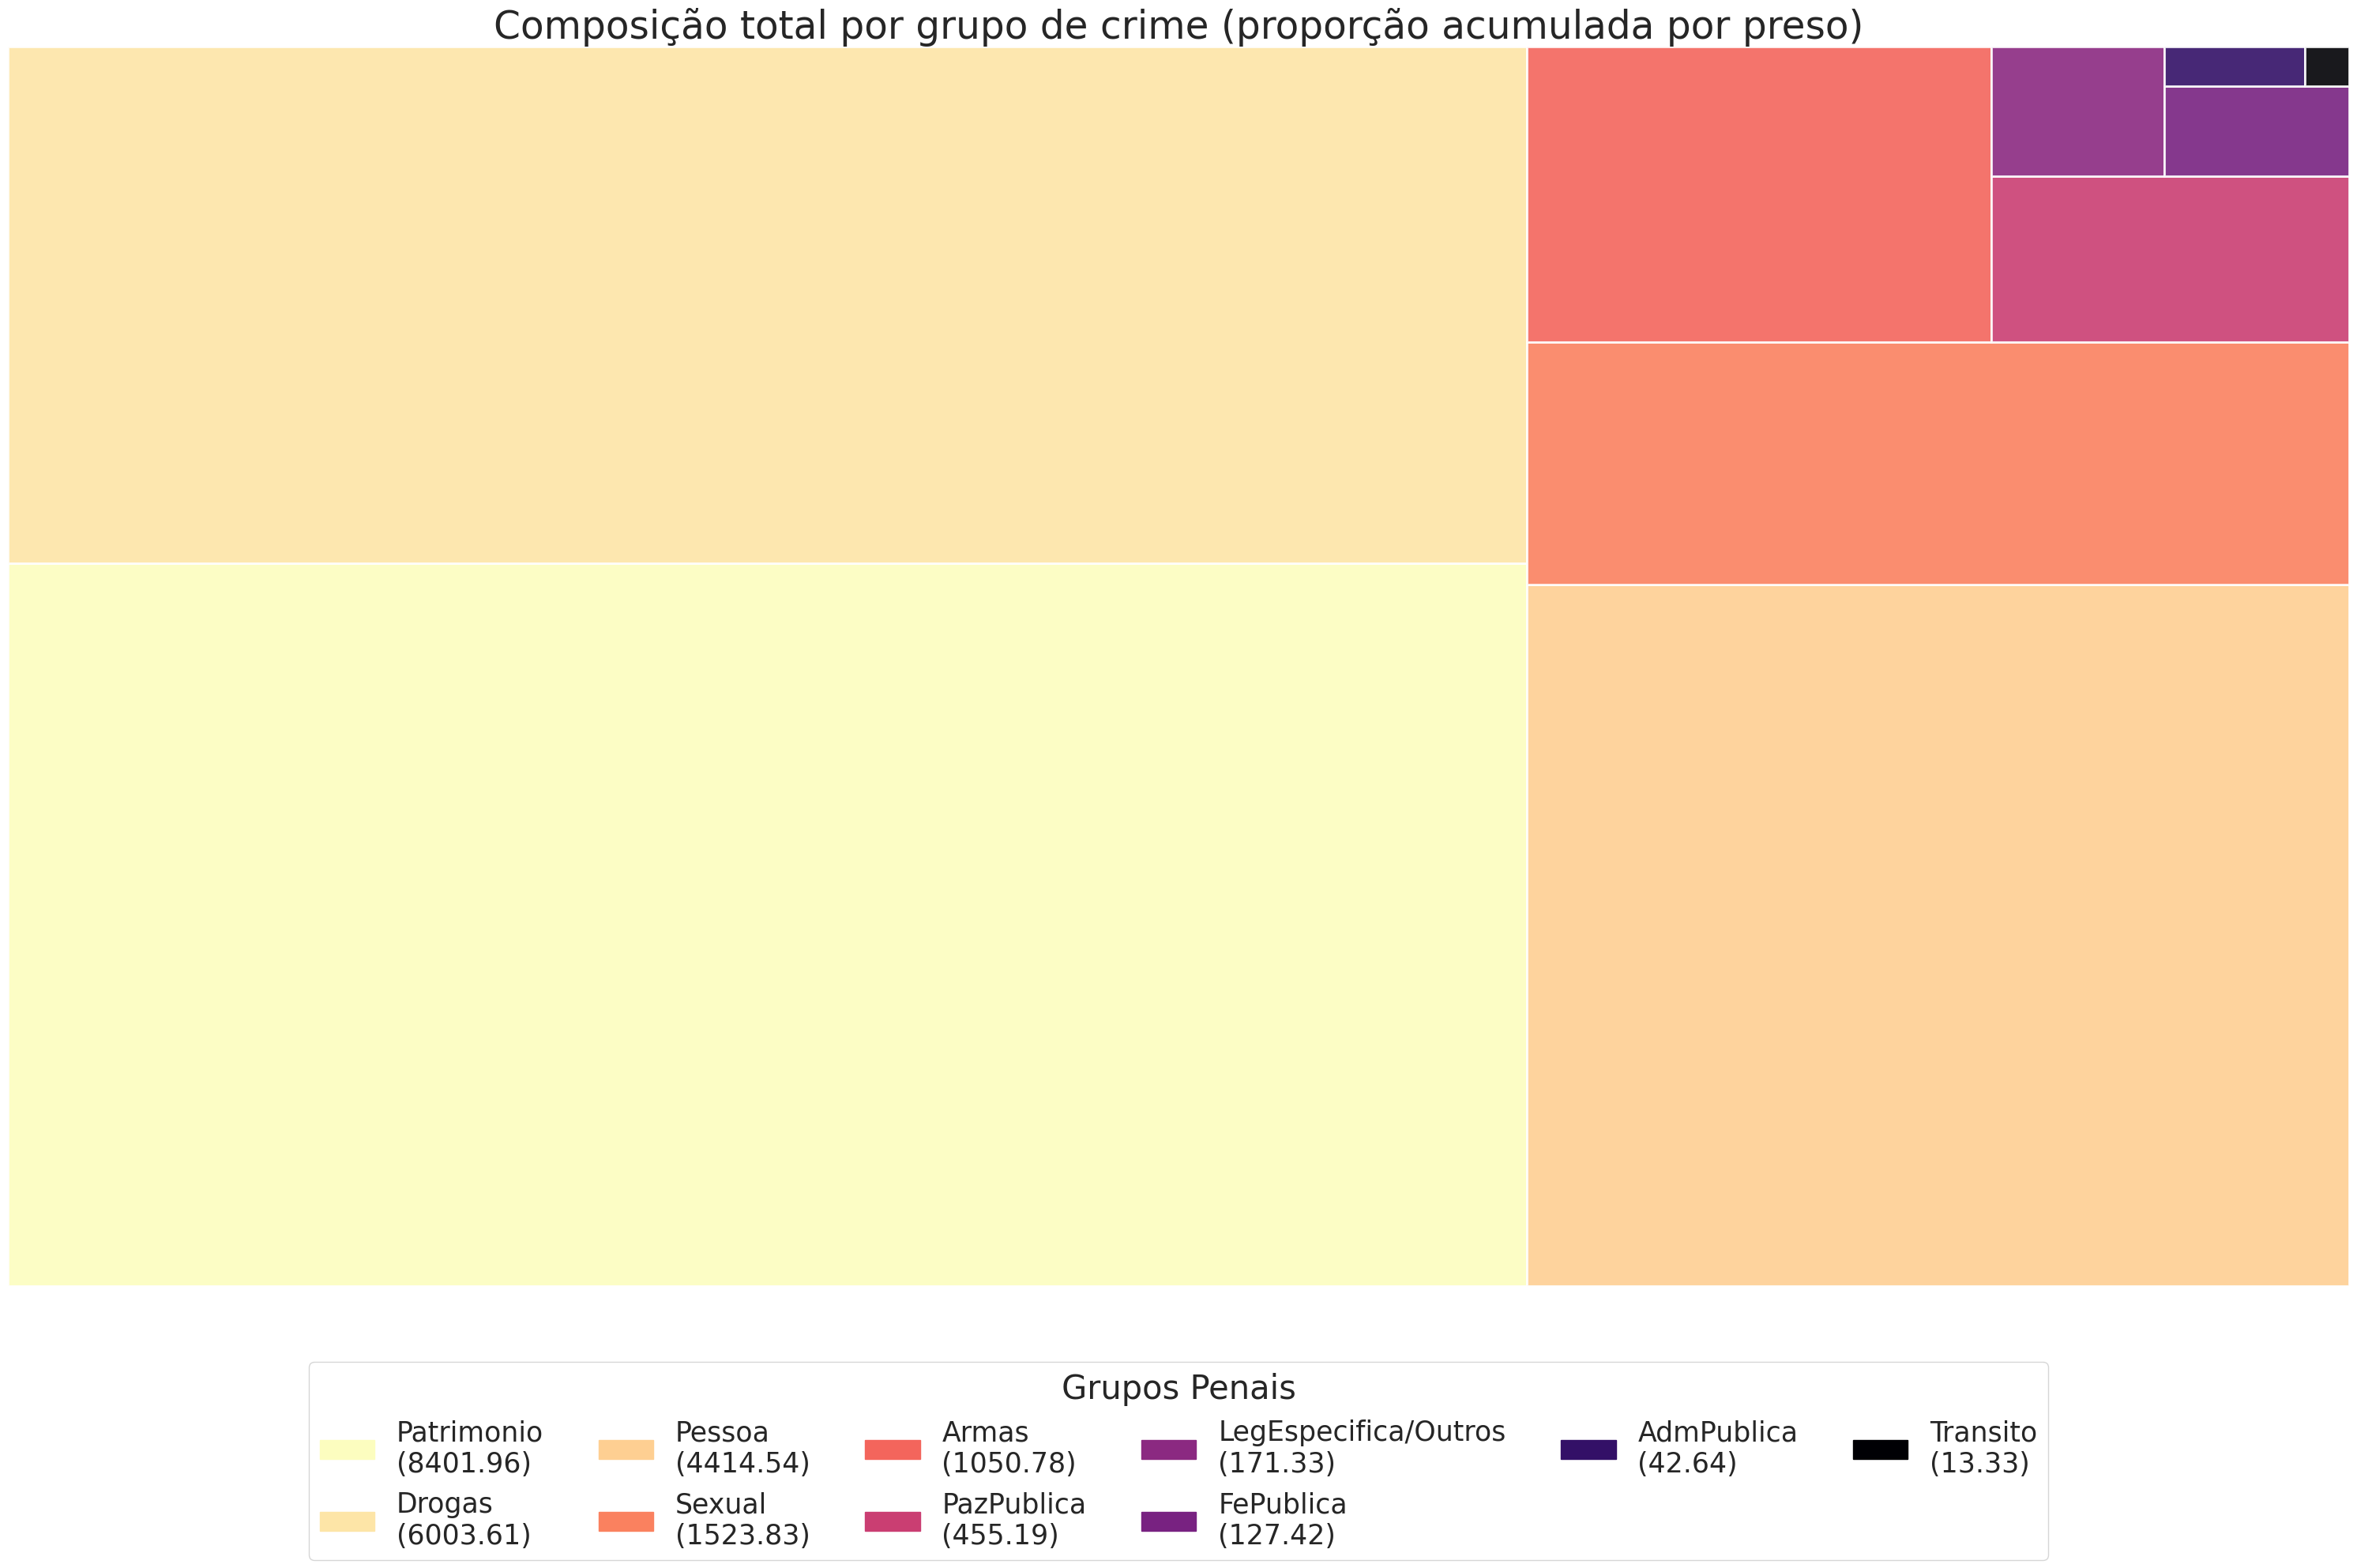

In [244]:
# Ordenar os grupos em ordem decrescente de valor acumulado (para deixar a visualização mais intuitiva)
soma_grupos_ordenado = dict(sorted(soma_grupos_filtrados.items(), key=lambda item: item[1], reverse=True))

# Dados para o gráfico
labels = [f"{k}\n({v:.2f})" for k, v in soma_grupos_ordenado.items()]
sizes = list(soma_grupos_ordenado.values())

# Aplicar normalização logarítmica aos valores para mapeamento de cores,
# o que permite maior contraste entre grupos pequenos e grandes
norm = LogNorm(vmin=min(sizes), vmax=max(sizes))

cmap = plt.cm.magma
colors = [cmap(norm(value)) for value in sizes]

# Criar gráfico
fig, ax = plt.subplots(figsize=(30, 20))
squarify.plot(
    sizes=sizes,
    color=colors,
    alpha=0.9,
    ax=ax,
    text_kwargs={'fontsize': 0},
    edgecolor='white',
    linewidth=2
)
plt.title("Composição total por grupo de crime (proporção acumulada por preso)", fontsize=35)
plt.axis('off')

legenda = [mpatches.Patch(color=colors[i], label=labels[i]) for i in range(len(labels))]

plt.legend(
    handles=legenda,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.05),
    fancybox=True,
    shadow=False,
    ncol=6,
    fontsize=25,
    title="Grupos Penais",
    title_fontsize=30
)

plt.tight_layout()
plt.show()

O gráfico revela que os crimes dos grupos 'Patrimônio', 'Drogas' e 'Pessoa' concentram a maior parte da composição penal proporcional por preso, com destaque evidente para os dois primeiros. Por outro lado, grupos como 'Administração Pública', 'Trânsito' e 'Fé Pública' apresentam representatividade muito baixa. Essa distribuição desigual indica que poucos grupos criminais dominam o perfil da população prisional.

Como a análise considera proporções por preso, ela possibilita comparações justas entre unidades com diferentes tamanhos populacionais. Esses dados servirão como base para investigar se há correlação entre determinados grupos de crimes e a ocorrência de óbitos prisionais, também analisados de forma proporcional por preso.

**Distribuição individual dos grupos penais proporcionais (por preso)**   
Para observar padrões, assimetrias e possíveis outliers, além de obter uma visão clara sobre a variação interna de cada grupo, foram gerados histogramas individuais para cada grupo de crime. Isso é importante para compreender a estrutura dos dados e orientar a escolha de testes estatísticos apropriados na investigação da correlação entre os grupos de crimes e os óbitos de natureza criminal.  
Em cada histograma, o eixo X representa a proporção de crimes daquele grupo por preso, ou seja, a quantidade de crimes registrados em relação ao total de presos em uma determinada unidade. Já o eixo Y indica a densidade da distribuição dessas proporções na base de dados, ou seja, a frequência relativa ajustada para a área total igual a 1, o que facilita a comparação entre os grupos. A transformação logarítmica foi aplicada com o objetivo de reduzir a assimetria das distribuições e tornar os dados mais apropriados para análises comparativas e estatísticas.



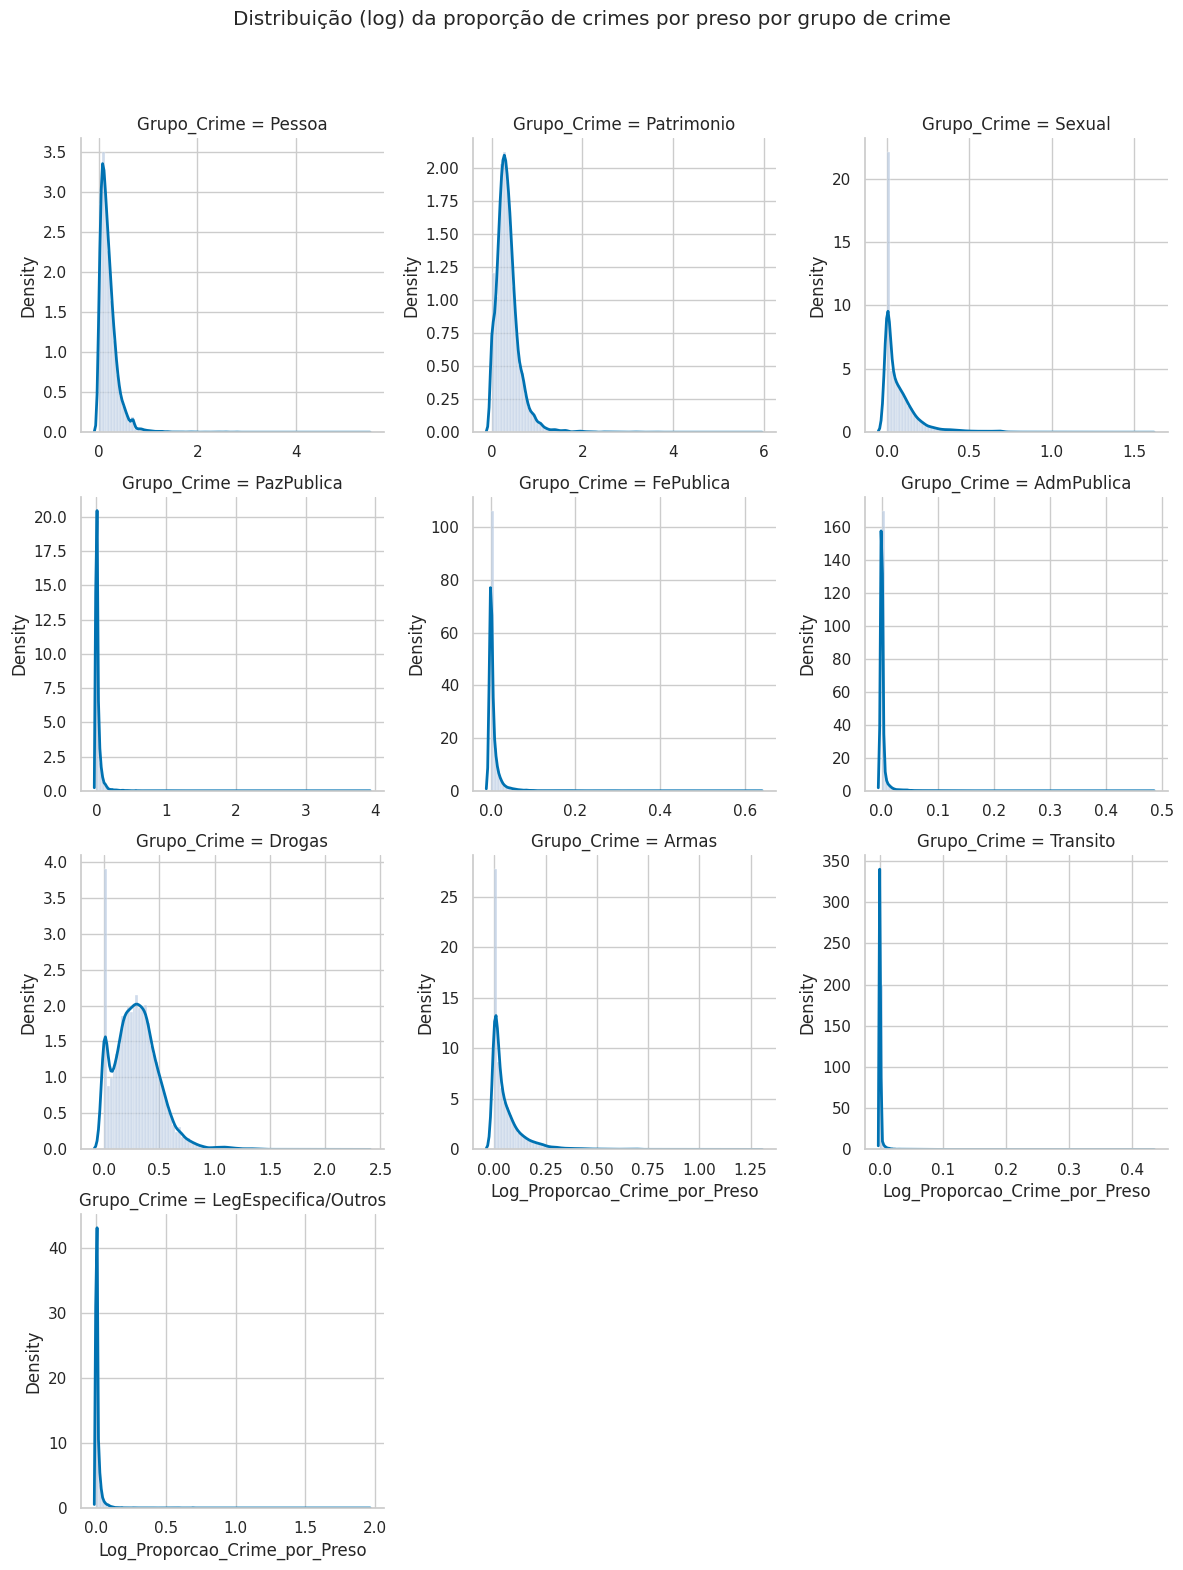

In [245]:
# Define a coluna que representa os óbitos criminais proporcionais por preso
coluna_obitos = 'Obitos_Criminais_Total_por_preso'

# Lista com os grupos penais válidos
grupos_validos = list(soma_grupos_filtrados.keys())

# Cria um df vazio que receberá os dados no formato long (por causa do seaborn)
df_long = pd.DataFrame()

# Loop para transformar os dados de cada grupo penal no formato long
for grupo in grupos_validos:
    nome_coluna = grupo + '_Total_por_preso'

    # Verifica se a coluna existe no df principal
    if nome_coluna in df_crimes_obitos.columns:
        temp = df_crimes_obitos[[nome_coluna]].copy()
        temp['Grupo_Crime'] = grupo
        temp['Proporcao_Crime_por_Preso'] = temp[nome_coluna]
        temp['Obitos_Criminais_por_Preso'] = df_crimes_obitos[coluna_obitos]
        df_long = pd.concat([df_long, temp[['Grupo_Crime', 'Proporcao_Crime_por_Preso', 'Obitos_Criminais_por_Preso']]])

df_long = df_long.reset_index(drop=True)

# Aplica transformação logarítmica para suavizar a assimetria dos dados (com log1p, o que permite lidar com zeros na base de dados)
df_long['Log_Proporcao_Crime_por_Preso'] = np.log1p(df_long['Proporcao_Crime_por_Preso'])

sns.set(style="whitegrid")
g = sns.FacetGrid(df_long, col="Grupo_Crime", col_wrap=3, height=4, sharex=False, sharey=False)

# O número de bins calculado por Freedaman-Diaconis era igual a 1108, mas a visualização ficava dificultada, então a escolha foi feita manualmente
g.map(sns.histplot, "Log_Proporcao_Crime_por_Preso", bins=90, color='#b0c4de', stat='density', alpha=0.6)
g.map(sns.kdeplot, "Log_Proporcao_Crime_por_Preso", color='#0072B2', lw=2)

plt.subplots_adjust(top=0.9)
g.fig.suptitle("Distribuição (log) da proporção de crimes por preso por grupo de crime")

plt.show()

Observa-se que, em todos os grupos, as distribuições continuam fortemente assimétricas à direita, com a maior parte das unidades concentradas em valores muito próximos de zero. Isso indica que a maior parte dos presídios possui proporções muito reduzidas de presos por grupo específico de crime, enquanto poucas unidades apresentam proporções mais elevadas.

Os grupos Pessoa, Patrimônio e Drogas apresentam distribuições mais largas e com maior variação interna, mesmo após a transformação logarítmica. Isso indica que, embora a assimetria tenha sido reduzida, ainda há uma heterogeneidade significativa entre as unidades, o que pode refletir tanto uma maior concentração de determinados crimes em algumas unidades quanto uma heterogeneidade real no perfil da população carcerária.

Por outro lado, os grupos Administração Pública, Trânsito, Fé Pública e Legislação Específica/Outros mostram distribuições altamente concentradas em valores muito baixos, com pouca dispersão. Isso pode estar relacionado ao fato de esses grupos reunirem um número bem menor de tipos penais e podem ser menos frequentes no sistema prisional. Já grupos como Pessoa, Patrimônio e Dignidade Sexual agregam uma diversidade maior de crimes, o que aumenta a heterogeneidade interna e contribui para distribuições mais amplas.


**Identificação de outliers**

Como a presença de outliers pode distorcer médias, correlações e modelos estatísticos, foi realizada sua identificação com base em valores acima do percentil 99 da distribuição log-transformada da proporção de crimes por preso em cada grupo de crime. O percentil 99 foi escolhido por permitir destacar apenas os casos mais extremos, focando nos valores que realmente se desviam de forma significativa do padrão observado, sem comprometer a maior parte da distribuição.

Isso foi necessário porque a substituição dos valores NaN por zero pode ter reduzido artificialmente a variabilidade dos dados, o que influencia a forma como os outliers aparecem.

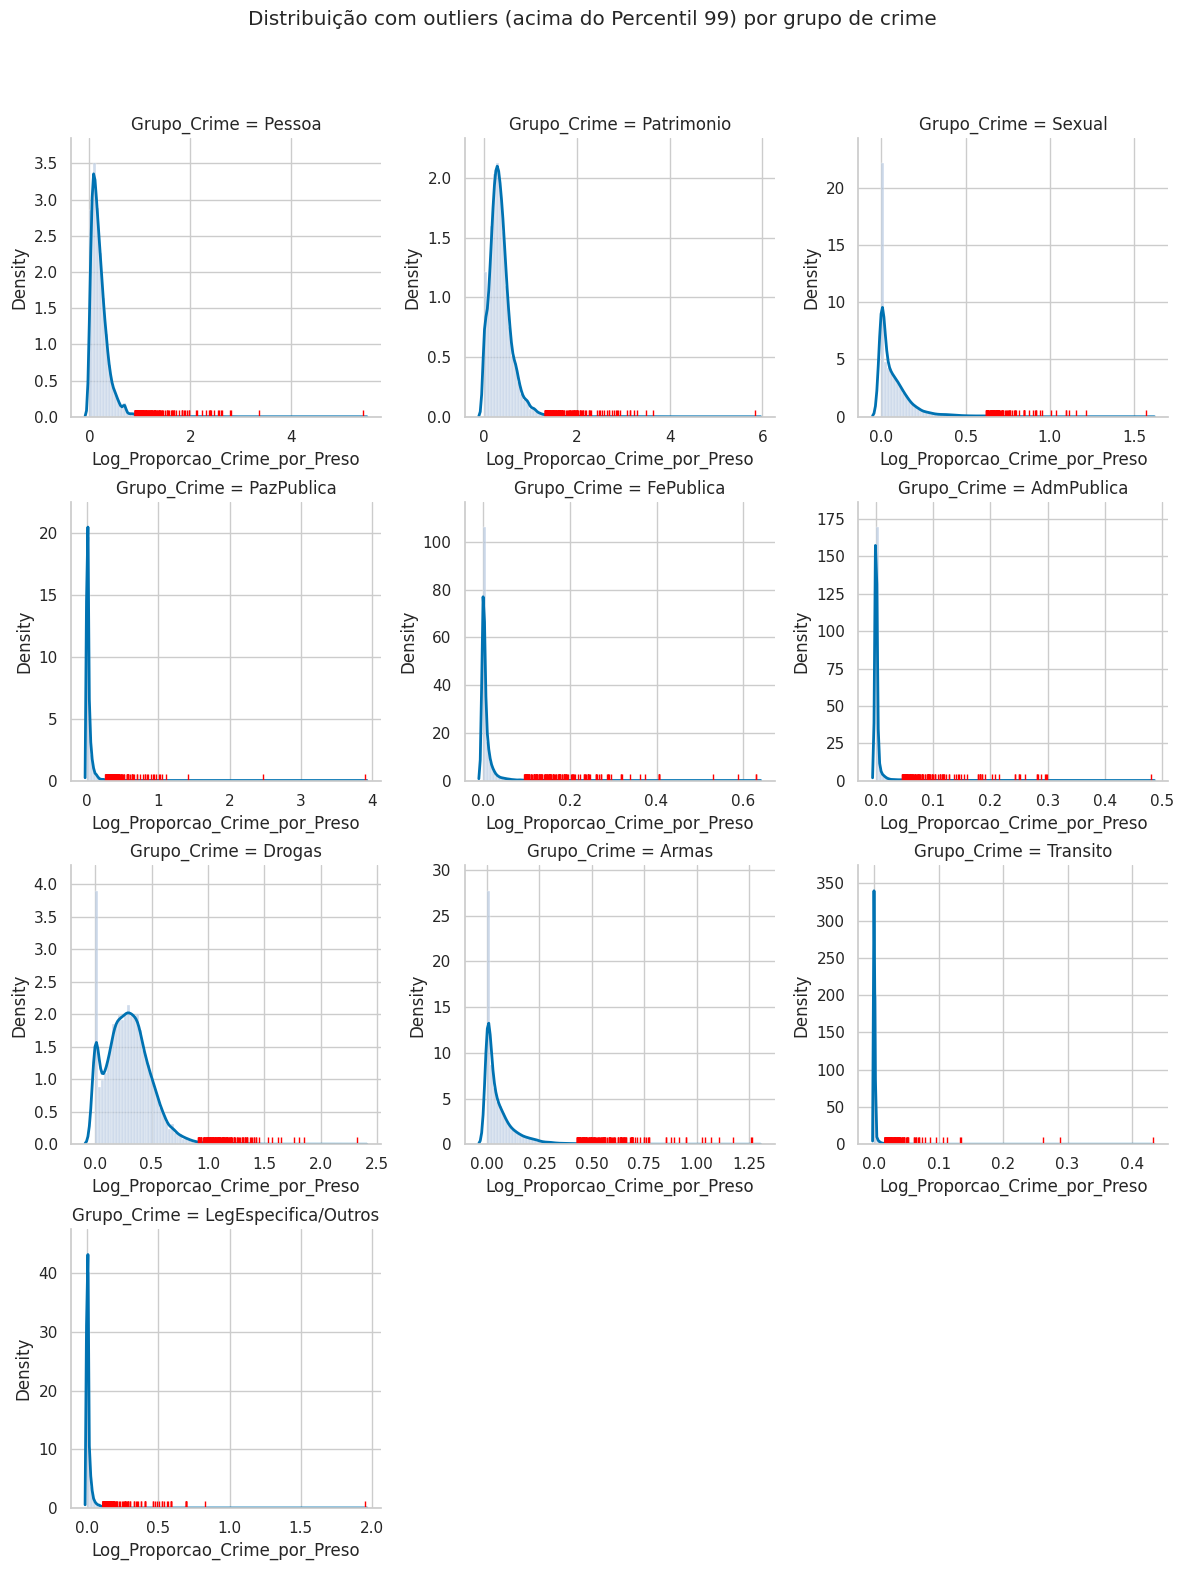

In [246]:
g = sns.FacetGrid(df_long, col="Grupo_Crime", col_wrap=3, height=4, sharex=False, sharey=False)

def plot_hist(data, **kwargs):
    # Histograma com KDE
    sns.histplot(data["Log_Proporcao_Crime_por_Preso"], bins=90, color='#b0c4de', stat='density', alpha=0.6)

    sns.kdeplot(data["Log_Proporcao_Crime_por_Preso"], color='#0072B2', lw=2)

    # Limite para outliers (percentil 99)
    lim_sup = data["Log_Proporcao_Crime_por_Preso"].quantile(0.99)

    # Marcar outliers com rugplot vermelho
    sns.rugplot(
        data=data[data["Log_Proporcao_Crime_por_Preso"] > lim_sup],
        x="Log_Proporcao_Crime_por_Preso",
        color='red',
        lw=1.5
)

g.map_dataframe(plot_hist)

plt.subplots_adjust(top=0.9)
g.fig.suptitle("Distribuição com outliers (acima do Percentil 99) por grupo de crime")

plt.show()


A análise mostrou a presença de outliers em todos os grupos de crimes. No grupo "Patrimônio", esses valores extremos estão bem afastados da maior parte dos dados, sugerindo situações pontuais com proporções muito elevadas. Já no grupo "Pessoa", embora também haja outliers, há um menor afastamento em relação ao corpo principal dos dados. No caso dos grupos "Paz Pública", "Fé Pública" e "Administração Pública", os outliers são mais frequentes, mas apresentam comportamentos diferentes. Em "Paz Pública", eles estão distribuídos ao longo de uma faixa mais ampla, com alguns valores se afastando consideravelmente do centro da distribuição. Já em "Fé Pública" e em "Administração Pública", os outliers tendem a se concentrar mais próximos do corpo principal dos dados, com menor distância em relação à densidade central. Já nos grupos "Drogas" e "Armas", os outliers aparecem bem deslocados à direita da distribuição,  indicando casos atípicos que podem estar associados, por exemplo, a regiões com maior incidência de tráfico ou porte ilegal de armas. Esses padrões mostram como é importante levar em conta os outliers nas análises, já que eles podem influenciar as medidas estatísticas.

**Distribuição dos óbitos criminais proporcionais à população prisional**  
Para entender a distribuição dos óbitos criminais no sistema prisional, utilizamos histogramas que representam a frequência proporcional de óbitos por preso nas unidades prisionais.

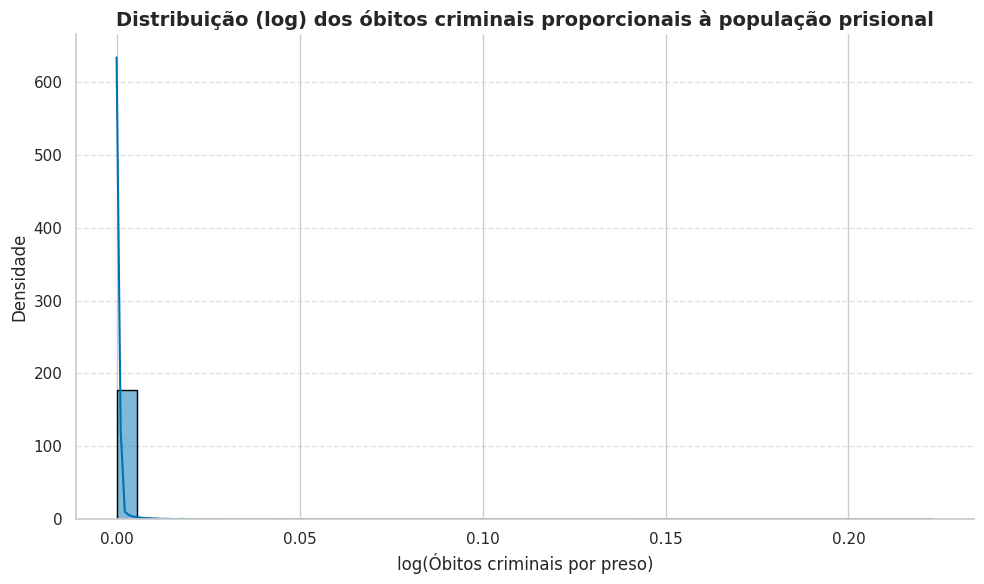

In [247]:
# Aplica transformação logarítmica para suavizar a assimetria
df_crimes_obitos['Log_Obitos_por_Preso'] = np.log1p(df_crimes_obitos['Obitos_Criminais_Total_por_preso'])

plt.figure(figsize=(10, 6))

sns.histplot(
    data=df_crimes_obitos,
    x='Log_Obitos_por_Preso',
    kde=True,
    stat='density',
    color='#0072B2',
    bins=40,
    edgecolor='black'
)

plt.title(
    'Distribuição (log) dos óbitos criminais proporcionais à população prisional',
    fontsize=14,
    weight='bold'
)
plt.xlabel('log(Óbitos criminais por preso)', fontsize=12)
plt.ylabel('Densidade', fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.6)
sns.despine()

plt.tight_layout()
plt.show()

A distribuição dos óbitos criminais proporcionais por preso apresenta uma forte concentração em valores próximos de zero. Mesmo após a aplicação de uma transformação logarítmica para suavizar a assimetria, os dados permanecem fortemente assimétricos à direita.
É importante destacar que a presença inicial de muitos valores ausentes (NaN), tratados como zero, contribuiu para essa concentração, podendo mascarar variações reais entre as unidades. Não se observam outliers evidentes, mas a alta densidade nos menores valores pode limitar a visualização de casos fora do padrão.



---



**Análise de correlação entre crimes e óbitos criminais**  
Dada a natureza dos dados analisados, optou-se pelo uso do coeficiente de correlação de Spearman (ρ) para investigar a relação entre os grupos de crimes e os óbitos criminais proporcionais à população prisional. A utilização desse coeficiente se deve às características observadas nas distribuições das variáveis, que apresentaram forte assimetria à direita, com a maior parte dos valores concentrados próximos de zero, além da presença de muitos valores nulos (ou originalmente ausentes) tratados como zero. Além disso, houve uma alta frequência de valores nulos (NaN), posteriormente tratados como zero, o que reforça a escolha por um método não paramétrico, menos sensível a outliers e à distribuição dos dados.

- **Testes de hipóteses**

Para investigar a relação entre a proporção de cada grupo de crime por preso (variável X) e os óbitos criminais por preso (variável Y), foi realizado um teste de correlação de Spearman para cada grupo de crime.

As hipóteses foram definidas da seguinte forma:

Hipótese nula (H0): Não existe correlação entre o grupo de crime (por preso) e a proporção de óbitos criminais. H0: p = 0  

Hipótese alternativa (H1): Existe correlação entre o grupo de crime (por preso) e a proporção de óbitos criminais. H1: p ≠ 0  
O nível de significância adotado foi α = 0,05.

- **Cálculo das correlações e intervalos de confiança**  


Para cada grupo de crime, foi calculado o coeficiente de correlação de Spearman (ρ) e o respectivo valor-p.  Além disso, para cada correlação, estimou-se o intervalo de confiança de 95% por meio de bootstrapping com 1000 reamostragens, dada a natureza não paramétrica da estatística.

/tmp/ipython-input-248-2253905197.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


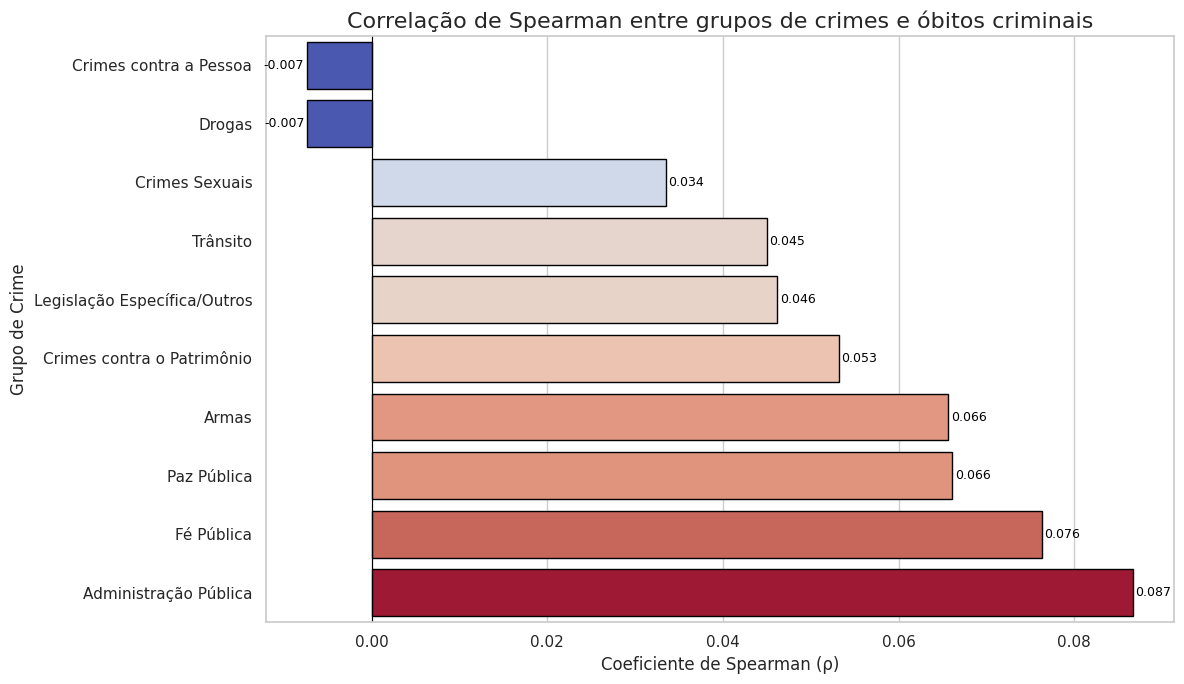

In [248]:
# Seleção das colunas de crimes
colunas_crime = [col for col in df_grupos_obitos_filtrados.columns if col != 'Obitos_Criminais_Total_por_preso']

resultados_correlacoes = {}

# Cálculo da correlação de Spearman para cada grupo de crime
for col in colunas_crime:
    rho, p_valor = stats.spearmanr(
        df_grupos_obitos_filtrados[col],
        df_grupos_obitos_filtrados['Obitos_Criminais_Total_por_preso']
    )
    resultados_correlacoes[col] = {'Spearman_rho': rho, 'p_valor': p_valor}

df_resultados_correlacoes = pd.DataFrame(resultados_correlacoes).T.sort_values(by='Spearman_rho', ascending=True).reset_index()
df_resultados_correlacoes = df_resultados_correlacoes.rename(columns={'index': 'Grupo_de_Crime'})

# Renomeação dos grupos de crime para melhor leitura
mapeamento_nomes = {
    'Pessoa_Total_por_preso': 'Crimes contra a Pessoa',
    'Drogas_Total_por_preso': 'Drogas',
    'Sexual_Total_por_preso': 'Crimes Sexuais',
    'Transito_Total_por_preso': 'Trânsito',
    'LegEspecifica/Outros_Total_por_preso': 'Legislação Específica/Outros',
    'Patrimonio_Total_por_preso': 'Crimes contra o Patrimônio',
    'Armas_Total_por_preso': 'Armas',
    'PazPublica_Total_por_preso': 'Paz Pública',
    'FePublica_Total_por_preso': 'Fé Pública',
    'AdmPublica_Total_por_preso': 'Administração Pública'
}
df_resultados_correlacoes['Grupo_de_Crime'] = df_resultados_correlacoes['Grupo_de_Crime'].map(mapeamento_nomes)

# Criação de um gradiente de cores baseado na força da correlação
norm = plt.Normalize(df_resultados_correlacoes['Spearman_rho'].min(), df_resultados_correlacoes['Spearman_rho'].max())
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
cores = [sm.to_rgba(value) for value in df_resultados_correlacoes['Spearman_rho']]

plt.figure(figsize=(12, 7))
ax = sns.barplot(
    data=df_resultados_correlacoes,
    y='Grupo_de_Crime',
    x='Spearman_rho',
    palette=cores,
    edgecolor='black'
)

# Linha de referência no zero
plt.axvline(0, color='black', linewidth=0.8)

# Anotação dos valores de rho nas barras
for i, valor in enumerate(df_resultados_correlacoes['Spearman_rho']):
    ax.text(
        valor + (0.0003 if valor >= 0 else -0.0003),
        i,
        f'{valor:.3f}',
        color='black',
        va='center',
        ha='left' if valor >= 0 else 'right',
        fontsize=9
    )

plt.title('Correlação de Spearman entre grupos de crimes e óbitos criminais', fontsize=16)
plt.xlabel('Coeficiente de Spearman (ρ)')
plt.ylabel('Grupo de Crime')

plt.tight_layout()
plt.show()

In [249]:
df_tabela_final = df_resultados_correlacoes.copy()

# Arredonda o coeficiente para 3 casas decimais
df_tabela_final['Coeficiente de Spearman (ρ)'] = df_tabela_final['Spearman_rho'].round(3)

# Formata o valor-p para 3 casas decimais, usando '< 0.001' quando for menor
df_tabela_final['Valor-p'] = df_tabela_final['p_valor'].apply(lambda p: f'{p:.3f}' if p >= 0.001 else '< 0.001')

# Adiciona coluna booleana para significância estatística
df_tabela_final['Significativo (p < 0.05)'] = df_tabela_final['p_valor'] < 0.05

# Inicializa as colunas para os intervalos de confiança e decisão
df_tabela_final['IC Inferior (95%)'] = np.nan
df_tabela_final['IC Superior (95%)'] = np.nan
df_tabela_final['Decisão'] = ''

# Calcula intervalo de confiança para a correlação de Spearman usando bootstrapping
def intervalo_confianca_spearman_bootstrap(vetor_crime, vetor_obitos, num_reamostragens=1000, nivel_significancia=0.05, semente=None):
    gerador_aleatorio = np.random.default_rng(seed=semente)
    lista_rho = []
    tamanho_amostra = len(vetor_crime)

    for _ in range(num_reamostragens):
        indices_reamostrados = gerador_aleatorio.choice(tamanho_amostra, size=tamanho_amostra, replace=True)
        rho, _ = stats.spearmanr(vetor_crime[indices_reamostrados], vetor_obitos[indices_reamostrados])
        lista_rho.append(rho)

    limite_inferior = np.percentile(lista_rho, 100 * (nivel_significancia / 2))
    limite_superior = np.percentile(lista_rho, 100 * (1 - nivel_significancia / 2))
    return limite_inferior, limite_superior

# Calcula ICs e decisão para cada grupo de crime
for idx, linha in df_tabela_final.iterrows():
    nome_coluna = linha['Grupo_de_Crime']

    # Recupera a coluna original pelo mapeamento, se tiver (caso contrário, use direto nome_coluna)
    col_original = [k for k, v in mapeamento_nomes.items() if v == nome_coluna][0]

    vetor_proporcao_crime = df_grupos_obitos_filtrados[col_original].values
    vetor_obitos_por_preso = df_grupos_obitos_filtrados['Obitos_Criminais_Total_por_preso'].values

    limite_inferior, limite_superior = intervalo_confianca_spearman_bootstrap(
        vetor_proporcao_crime,
        vetor_obitos_por_preso,
        num_reamostragens=1000,
        nivel_significancia=0.05
    )

    df_tabela_final.at[idx, 'IC Inferior (95%)'] = limite_inferior
    df_tabela_final.at[idx, 'IC Superior (95%)'] = limite_superior

    # Decisão baseada se IC contém zero
    if limite_inferior > 0 or limite_superior < 0:
        df_tabela_final.at[idx, 'Decisão'] = 'Significativo'
    else:
        df_tabela_final.at[idx, 'Decisão'] = 'Não Significativo'

colunas_exibir = [
    'Grupo_de_Crime',
    'Coeficiente de Spearman (ρ)',
    'Valor-p',
    'Significativo (p < 0.05)',
    'IC Inferior (95%)',
    'IC Superior (95%)',
    'Decisão'
]

df_tabela_final = df_tabela_final[colunas_exibir]

display(df_tabela_final)

,Grupo_de_Crime,Coeficiente de Spearman (ρ),Valor-p,Significativo (p < 0.05),IC Inferior (95%),IC Superior (95%),Decisão
0,Crimes contra a Pessoa,-0.007,0.352,False,-0.022251,0.008345,Não Significativo
1,Drogas,-0.007,0.355,False,-0.022819,0.006539,Não Significativo
2,Crimes Sexuais,0.034,< 0.001,True,0.019583,0.046238,Significativo
3,Trânsito,0.045,< 0.001,True,0.029070,0.064194,Significativo
4,Legislação Específica/Outros,0.046,< 0.001,True,0.030872,0.061502,Significativo
5,Crimes contra o Patrimônio,0.053,< 0.001,True,0.038601,0.067785,Significativo
6,Armas,0.066,< 0.001,True,0.051788,0.080005,Significativo
7,Paz Pública,0.066,< 0.001,True,0.050968,0.080543,Significativo
8,Fé Pública,0.076,< 0.001,True,0.061489,0.090926,Significativo
9,Administração Pública,0.087,< 0.001,True,0.069273,0.103764,Significativo


Os ICs podem ser visualizados a seguir.

/tmp/ipython-input-250-2745715192.py:8: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(


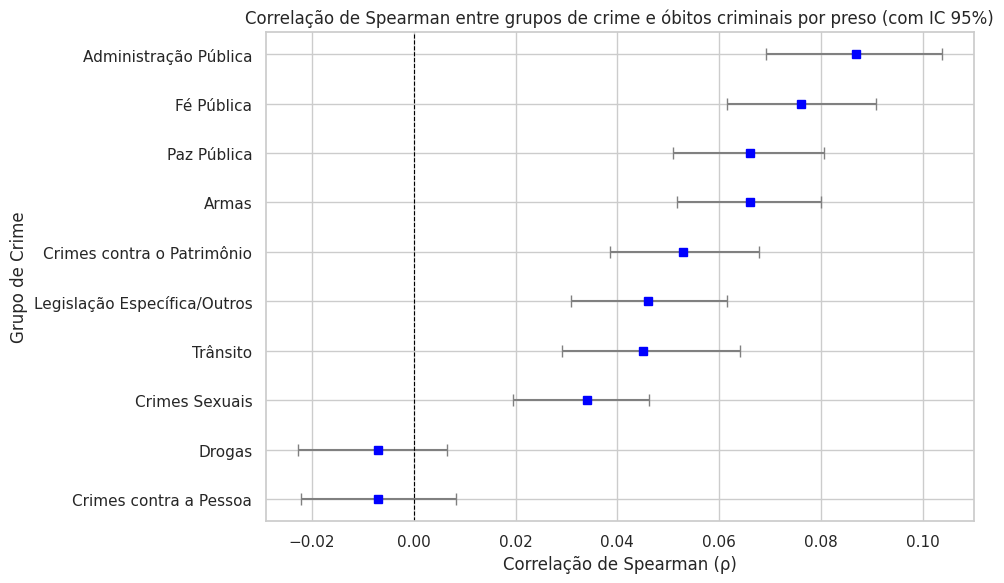

In [250]:
plt.figure(figsize=(10, 6))
sns.set(style='whitegrid')

# Ordena do menor para o maior para visualização invertida
df_plot = df_tabela_final.sort_values(by='Coeficiente de Spearman (ρ)', ascending=True)

# Gráfico com barra de erro (erro = metade do intervalo)
plt.errorbar(
    x=df_plot['Coeficiente de Spearman (ρ)'],
    y=df_plot['Grupo_de_Crime'],
    xerr=[
        df_plot['Coeficiente de Spearman (ρ)'] - df_plot['IC Inferior (95%)'],
        df_plot['IC Superior (95%)'] - df_plot['Coeficiente de Spearman (ρ)']
    ],
    fmt='o',
    ecolor='gray',
    capsize=4,
    color='blue',
    marker='s',
    markersize=6,
    linestyle='None'
)


plt.title('Correlação de Spearman entre grupos de crime e óbitos criminais por preso (com IC 95%)')
plt.xlabel('Correlação de Spearman (ρ)')
plt.ylabel('Grupo de Crime')
plt.axvline(0, color='black', linestyle='--', linewidth=0.8)  # Linha de referência no 0
plt.tight_layout()
plt.show()


- **Conclusões**

Os resultados obtidos indicam correlações positivas muito fracas entre a maioria dos grupos de crime e os óbitos criminais. O grupo com maior associação foi "AdmPublica", com um coeficiente de ρ = 0.087, seguido por "FePublica" (ρ = 0.076) e "PazPublica" (ρ = 0.066). Apesar dos valores baixos de correlação, os respectivos valores de p foram extremamente pequenos, indicando significância estatística devido ao grande número de observações.

Por outro lado, os grupos "Drogas" e "Pessoa" apresentaram coeficientes negativos próximos de zero (ρ ≈ -0.007), sem significância estatística (p > 0.05), sugerindo ausência de associação monotônica com os óbitos criminais.

Em resumo, não foram encontradas correlações fortes ou moderadas entre os grupos de crimes e os óbitos criminais proporcionais por preso. Embora alguns grupos tenham apresentado correlações estatisticamente significativas (ρ < 0.09), os intervalos de confiança estimados via bootstrapping indicam que apenas "Administração Pública", "Fé Pública" e "Paz Pública" possuem ICs que não incluem o valor zero, sustentando a significância. Ainda assim, as associações permanecem muito fracas, o que reforça a consideração de outros fatores que possam influenciar os óbitos no sistema prisional.



---



**Regressão**  
Para investigar a correlação entre os grupos de crimes e os óbitos criminais por preso, foram aplicadas abordagens de regressão, considerando que a variável-alvo, \"óbitos criminais por preso\", é contínua. Dada a assimetria dos dados e a concentração de grande parte dos valores próximos a zero, optou-se pelo modelo de Random Forest Regressor, que é robusto a distribuições assimétricas e a presença de valores extremos. Além disso, foi aplicada uma Regressão Linear Múltipla para fins comparativos. O objetivo foi prever a taxa de óbitos criminais com base na proporção de crimes cometidos em diferentes grupos (como crimes contra a pessoa, patrimônio, tráfico, entre outros).


Tratamento dos dados
- Dados de entrada: As colunas que representam a proporção de crimes cometidos por preso em cada grupo (ex.: 'Pessoa_Total_por_preso', 'Tráfico_Total_por_preso', etc).

- Variável-alvo: A variável 'Obitos_Criminais_Total_por_preso' foi transformada em uma variável binária, na qual:
  - 0 indica unidades prisionais sem registro de óbito criminal, e
  - 1 indica unidades que apresentaram pelo menos um óbito criminal.

- Tratamento de valores ausentes: Como mencionado anteriormente, os NaNs foram tratados como 0, preservando a estrutura dos dados. Isso foi mantido nesta etapa para evitar a exclusão de registros com dados relevantes, assumindo que a ausência representa ausência do crime naquele grupo.

- Transformação logarítmica: Para lidar com a assimetria das distribuições (tanto das features quanto da variável-alvo), foi utilizada a transformação log1p(x) = log(1 + x). Isso reduz o impacto de outliers e torna a distribuição mais próxima da normal.

- Normalização: Como a regressão linear é sensível à escala das variáveis, aplicou-se o MinMaxScaler para ajustar as features ao intervalo [0, 1] antes de treinar o modelo de Regressão Linear Múltipla. Para o Random Forest, essa normalização não foi necessária, pois esse modelo é robusto a diferentes escalas das variáveis.

Treinamento e Avaliação do Modelo

Um dos modelos escolhidos foi o Random Forest Regressor. O modelo foi treinado com 70% dos dados, reservando os 30% restantes para teste. Considerando a alta proporção de zeros no dataset — resultado do tratamento de valores originalmente ausentes (NaN), convertidos para zero por representarem a ausência legítima dos dados — optou-se por complementar a avaliação com validação cruzada, visando garantir maior confiabilidade nas métricas obtidas. O desempenho foi avaliado com as seguintes métricas:

Os modelos foram avaliados pelas seguintes métricas:
- R² Score: mede o quanto da variância dos dados é explicada pelo modelo. Valores mais próximos de 1 indicam um bom ajuste. Essa métrica foi escolhida por permitir avaliar diretamente quanto da variação nos óbitos criminais por preso pode ser explicada pelas proporções dos diferentes grupos de crimes. É útil neste contexto, já que buscamos entender se há uma relação sistemática entre os tipos de crime e a ocorrência de óbitos.

- MAE (Mean Absolute Error): representa o erro absoluto médio entre os valores previstos e os observados, ou seja, mede, em média, o quanto o modelo erra. Por ser mais robusto a distribuições assimétricas e à presença de muitos zeros, características presentes nos dados analisados, o MAE foi escolhido como uma métrica complementar ao R², ajudando a avaliar o desempenho do modelo mesmo em cenários com valores extremos ou baixa frequência de eventos.

- MedAE (Median Absolute Error): escolhido por ser robusto a outliers e distribuições assimétricas.



In [300]:
from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.metrics import r2_score, mean_absolute_error, median_absolute_error
from sklearn.linear_model import LinearRegression
import matplotlib.patheffects as path_effects
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, median_absolute_error

In [310]:
def imprimir_metricas(nome_modelo, y_true, y_pred):
    """
    Função para calcular e imprimir métricas principais para modelos de regressão.

    Parâmetros:
    - nome_modelo (str): Nome do modelo.
    - y_true (array): Valores reais.
    - y_pred (array): Valores previstos.
    """
    dados = {
        'R² Score': [r2_score(y_true, y_pred)],
        'MAE': [mean_absolute_error(y_true, y_pred)],
        'MedAE': [median_absolute_error(y_true, y_pred)]
    }

    df_metricas = pd.DataFrame(dados)
    print(f"--- Métricas para {nome_modelo} ---")
    display(df_metricas.style.format("{:.4f}"))

def comparar_modelos(nome_modelo1, y_true1, y_pred1, nome_modelo2, y_true2, y_pred2):
    dados = {
        'Modelo': [nome_modelo1, nome_modelo2],
        'R²': [r2_score(y_true1, y_pred1), r2_score(y_true2, y_pred2)],
        'MAE': [mean_absolute_error(y_true1, y_pred1), mean_absolute_error(y_true2, y_pred2)],
        'MedAE': [median_absolute_error(y_true1, y_pred1), median_absolute_error(y_true2, y_pred2)]
    }

    df_comp = pd.DataFrame(dados)

    for metric in ['R²', 'MAE', 'MedAE']:
        plt.figure(figsize=(6, 4))

        cores = ['steelblue', 'darkorange']
        valores = df_comp[metric]
        bars = plt.bar(df_comp['Modelo'], valores, color=cores, edgecolor='black')

        y_min, y_max = float('inf'), float('-inf')

        for bar in bars:
            valor = bar.get_height()
            texto = f'{valor:.4f}' if abs(valor) >= 0.01 else f'{valor:.6f}'
            intervalo = valores.max() - valores.min()
            y_offset = intervalo * 0.02 if intervalo > 0 else 0.0005
            y_pos = valor + y_offset if valor >= 0 else valor - y_offset

            y_max = max(y_max, y_pos, valor)
            y_min = min(y_min, y_pos, valor)

            plt.text(
                bar.get_x() + bar.get_width() / 2,
                y_pos,
                texto,
                ha='center',
                va='bottom' if valor >= 0 else 'top',
                fontsize=9
            )

        margem = (y_max - y_min) * 0.15 if (y_max - y_min) > 0 else 0.01

        if metric == 'R²':
            plt.ylim(y_min - margem, y_max + margem)
        else:
            plt.ylim(0, y_max + margem)

        plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
        plt.title(f'Comparação de {metric}')
        plt.ylabel(metric)
        plt.tight_layout()
        plt.show()

Aplicação do Random Forest Regressor

In [253]:
# Definir as colunas dos grupos de crimes (features)
colunas_crimes = [col for col in df_grupos_obitos_filtrados.columns if col != 'Obitos_Criminais_Total_por_preso']

# Separar X e y do DataFrame
X = df_grupos_obitos_filtrados[colunas_crimes].copy()
y = df_grupos_obitos_filtrados['Obitos_Criminais_Total_por_preso'].copy()

# Aplicar transformação log1p nas features para suavizar assimetria
X_log = np.log1p(X)

# Dividir dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X_log, y, test_size=0.3, random_state=42
)

# Instanciar e treinar o Random Forest Regressor
rf = RandomForestRegressor(
    n_estimators=50,
    max_depth=5,
    random_state=42
)
rf.fit(X_train, y_train)

# Previsões
y_pred_rf = rf.predict(X_test)

# Métricas
imprimir_metricas("Random Forest Regressor", y_test, y_pred_rf)

--- Métricas para Random Forest Regressor ---


,R² Score,MAE,MedAE
0,-0.0359,0.0007,0.0003


- Ajuste dos hiperparâmetros do Random Forest  
Para isso iremos utilizar o Grid Search (pega várias combinações de hiperparâmetros e testa todas com validação cruazada).

In [313]:
# Parâmetros a testar
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10, None],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5, 10]
}

# Instância do modelo base
rf = RandomForestRegressor(random_state=42)

# Validação cruzada com busca em grade
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='neg_mean_absolute_error',  # ou 'r2', etc.
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# Melhor modelo
melhor_rf = grid_search.best_estimator_

# Avaliar no conjunto de teste
y_pred = melhor_rf.predict(X_test)
imprimir_metricas("Random Forest Regressor (ajustado)", y_test, y_pred)

--- Métricas para Random Forest Regressor (ajustado) ---


,R² Score,MAE,MedAE
0,-0.0926,0.0008,0.0002


Aplicação da Regressão Linear Múltipla

In [254]:
regressao_linear = LinearRegression()

# Treinar o modelo
regressao_linear.fit(X_train, y_train)

# Fazer previsões
y_pred_lr = regressao_linear.predict(X_test)

# Imprimir as métricas
imprimir_metricas("Regressão Linear Múltipla", y_test, y_pred_lr)

--- Métricas para Regressão Linear Múltipla ---


,R² Score,MAE,MedAE
0,-0.0011,0.0007,0.0004


Comparação dos modelos

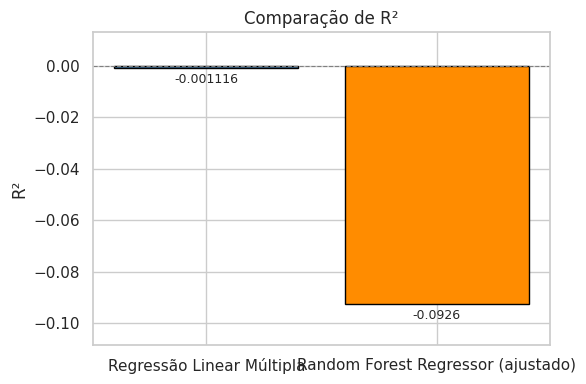

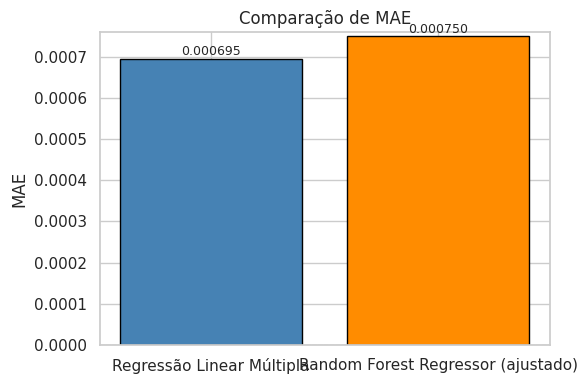

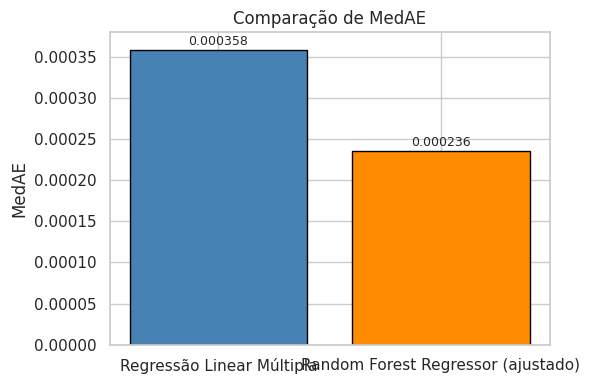

In [318]:
comparar_modelos(
    "Regressão Linear Múltipla", y_test, y_pred_lr,
    "Random Forest Regressor (ajustado)", y_test, y_pred
)

Com base nas métricas apresentadas, o modelo de Regressão Linear Múltipla é ligeiramente melhor. Embora o Random Forest tenha obtido um MedAE ligeiramente menor (0.0002 contra 0.0004), esse ganho é pequeno e não compensa o fato de ter um R² Score consideravelmente mais negativo (−0.0926 contra −0.0011), indicando que explica ainda menos da variabilidade dos dados. Além disso, o MAE do Random Forest também foi um pouco maior (0.0008 contra 0.0007).

Aplicando a validação cruzada

In [317]:
# Fazer previsões com validação cruzada (no conjunto de treino)
y_pred_cv = cross_val_predict(regressao_linear, X_train, y_train, cv=5)

# Imprimir as métricas da validação cruzada
imprimir_metricas("Regressão Linear Múltipla (com validação cruzada)", y_train, y_pred_cv)

--- Métricas para Regressão Linear Múltipla (com validação cruzada) ---


,R² Score,MAE,MedAE
0,0.0004,0.0007,0.0004


Com base nas métricas da validação

In [319]:
print("Estatísticas descritivas da variável-alvo (óbitos por preso):")
print(y.describe())

Estatísticas descritivas da variável-alvo (óbitos por preso):
count    15951.000000
mean         0.000357
std          0.004484
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          0.250000
Name: Obitos_Criminais_Total_por_preso, dtype: float64


- Avaliação do modelo final no conjunto de teste

In [ ]:
# Modelo final depois do Grid Search
best_rf = grid_search.best_estimator_

# Nova validação cruzada com o modelo final, só pra garantir que ele é consistente
scores = cross_val_score(
    best_rf,
    X_train,
    y_train,
    cv=5,
    scoring='f1'
)

print("F1 médio após ajuste final:", scores.mean())
print("Scores em cada fold:", scores)

# Teste final nos dados que estavam separados (X_test, y_test)
y_pred_best = best_rf.predict(X_test)
y_proba_best = best_rf.predict_proba(X_test)[:, 1]

imprimir_metricas("Random Forest Final", y_test, y_pred_best, y_proba_best)

Crimes que mais influenciaram a predição

In [ ]:
importances = best_rf.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

feature_importance_df.head(10)

**Conclusões finais**  
Com base nas características dos dados e nos resultados das regressões aplicadas, conclui-se que a abordagem via modelos de regressão não é adequada para explicar ou prever a ocorrência de óbitos criminais nas unidades prisionais.

A elevada concentração de zeros, a assimetria acentuada da variável-alvo e o baixo poder explicativo dos modelos, evidenciado por R² próximos ou inferiores a zero, indicam que os grupos de crimes não possuem força preditiva suficiente para justificar a variabilidade observada nos óbitos por preso.

Além disso, como dito anteriormente a análise de correlação de Spearman revelou correlações positivas muito fracas entre a maioria dos grupos de crime e os óbitos criminais. O grupo com maior associação foi Administração Pública (ρ = 0.087), seguido por Fé Pública (ρ = 0.076) e Paz Pública (ρ = 0.066). Apesar da significância estatística dessas correlações, seus valores baixos indicam que a associação é mínima.

Portanto, ainda que haja indícios de associações estatisticamente significativas para alguns grupos, essas relações são muito fracas em termos práticos, sugerindo que os óbitos nas unidades prisionais provavelmente decorrem de outros fatores não incluídos nesta análise. Assim, os grupos de crimes não se mostram suficientes para explicar ou prever a ocorrência de óbitos no sistema prisional.



---

